## Variables experimentales
**Variables independientes:**
-  Voltaje de frenado: $U_c \; \left[\text{V}\right]$ (medida directa)
   -  Rango: $U_c \in \left[-4.00, 0.00\right] \text{ V}$
   -  Incertidumbre: $\Delta U_c = U_c \cdot 1\% + (5 \text{ V}) \cdot 0.5\%$ [(según el facricante)](https://www.leybold-shop.com/sensor-cassy-2-524013.html)
-  Longitud de onda: $\lambda \; \left[\text{nm}\right]$ (especificada por el fabricante)
   -  Valores: $\lambda \in \left\{578 \text{ nm}, 546 \text{ nm}, 436 \text{ nm}, 405 \text{ nm}, 365 \text{ nm}\right\}$
   -  Incertidumbre: $\Delta \lambda = 2 \text{ nm}$ [(referencias en la guía)](https://www.leybold-shop.com/catalogsearch/result/?q=Interference+filter)
-  Apertura del diafragma: $A \; \left[\text{u.a.l}\right]$ (unidades arbitrarias de longitud, medida directa)
   -  Rango: $A \in \left[0.0, 3.0\right] \text{ u.a.l.}$
   -  Incertidumbre: $\Delta A = 0.2 \text{ u.a.l.}$ (mitad de la apreciación intrumental $0.5/2$)

**Variables dependientes:**
-  Corriente fotoeléctrica: $I \; \left[\text{pA}\right]$ (medida directa)
   -  Rango: $I \in \left[-20.0, 100.0\right] \text{ pA}$
   -  Incertidumbre: $\Delta I = 0.1 \text{ pA}$ [(incertidumbre instrumental)](https://www.leybold-shop.com/sensor-cassy-2-524013.html)

In [1]:
#@title Librerías utilizadas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import t

In [2]:
#@title Funciones
def data_from_file(file_dir):
  data_p = pd.read_csv(file_dir, delimiter=';', header=1)
  data_s = pd.read_csv(file_dir, delimiter=';', header=None, nrows=1)
  data_p = np.transpose(data_p.to_numpy(dtype=np.float64))
  data_s = data_s.loc[0][1::2].tolist()

  medidas = []
  for i in range(len(data_s)):
    U_c =  data_p[2*i]
    I =  data_p[2*i + 1]
    medidas.append({
      'parametro_variable': data_s[i],
      'U_c': U_c[~np.isnan(U_c)],
      'I': I[~np.isnan(I)],
    })

  return medidas


def percentile_range(Range, x, y):
  X, Y = x.copy(), y.copy()  # Avoid pass-by-reference alterations

  Y_below = np.percentile(Y, Range[0]*100, method='inverted_cdf')
  Y_above = np.percentile(Y, Range[1]*100, method='inverted_cdf')

  mask_below = Y >= Y_below
  mask_above = Y <= Y_above

  X = X[mask_below & mask_above]
  Y = Y[mask_below & mask_above]

  N = len(Y)
  N_below = np.ceil(Range[0]*N) - (~mask_below).sum()
  N_above = np.ceil((1 - Range[1])*N) - (~mask_above).sum()

  new_X = X.copy()
  new_Y = Y.copy()

  i = j = k = 0
  while i < N_below:
    if Y[k] == Y_below:
      new_X = np.delete(new_X, k - i)
      new_Y = np.delete(new_Y, k - i)
      i += 1
    k += 1

  k = -1
  while j < N_above:
    if Y[k] == Y_above:
      new_X = np.delete(new_X, k + j)
      new_Y = np.delete(new_Y, k + j)
      j += 1
    k -= 1

  return new_X, new_Y


def OLS_regr(X, Y, **kwargs):
  """
  Realiza una regresión lineal por mínimos cuadrados ordinarios (OLS).

  Calcula los parámetros `a` y `b` de una recta ajustada `Y = aX + b`, junto con los errores estándar,
  el coeficiente de correlación de Pearson, y opcionalmente, las incertidumbres de los parámetros si se
  proporcionan errores en las variables `X` e `Y`.

  Parameters
  ----------
  X : array_like
      Vector de valores independientes.
  Y : array_like
      Vector de valores dependientes.
  **kwargs : dict, opcional
      Argumentos opcionales que permiten incluir incertidumbres en los datos:

      - 'Delta_X' : array_like
          Errores estándar asociados a cada valor de `X`.
      - 'Delta_Y' : array_like
          Errores estándar asociados a cada valor de `Y`.

  Returns
  -------
  a : float
      Pendiente de la recta ajustada.
  b : float
      Ordenada al origen (intersección con el eje Y).
  SE_a : float
      Error estándar de la pendiente.
  SE_b : float
      Error estándar de la ordenada al origen.
  r : float
      Coeficiente de correlación de Pearson.

  Si se proporcionan `Delta_X` y `Delta_Y`, también se devuelven:

  Delta_a : float
      Incertidumbre en la pendiente considerando los errores en `X` e `Y`.
  Delta_b : float
      Incertidumbre en la ordenada al origen considerando los errores en `X` e `Y`.

  Notes
  -----
  La función implementa una regresión lineal clásica usando el método de mínimos cuadrados.
  Si el número de observaciones es menor a 30, se aplica una corrección de Student para los errores estándar.
  """

  N = len(X)
  SX = np.sum(X)
  SY = np.sum(Y)
  SXX = np.sum(X*X)
  SYY = np.sum(Y*Y)
  SXY = np.sum(X*Y)

  P1 = SX*SY - N*SXY
  P2 = SX*SXY - SY*SXX
  Q = SX**2 - N*SXX

  a = P1/ Q
  b = P2 / Q

  linear_X = a*X + b
  ji2 = np.sum(np.power(Y - linear_X, 2))

  SE_a = np.sqrt((ji2/(N - 2))*(N/(-Q)))
  SE_b = np.sqrt((ji2/(N - 2))*(SXX/(-Q)))
  r = (-P1)/(np.sqrt((-Q)*(N*SYY - SY**2)))

  if N < 30:
    SE_a *= t.ppf(.975, N - 1)
    SE_b *= t.ppf(.975, N - 1)

  for key, value in kwargs.items():
    if key == 'Delta_X':
      Delta_X = value
      continue
    elif key == 'Delta_Y':
      Delta_Y = value
      continue
  try:
    Delta_X
    Delta_Y
  except NameError:
    return a, b, SE_a, SE_b, r
  else:
    Delta_SX = np.sqrt(np.sum(np.power(Delta_X, 2)))
    Delta_SY = np.sqrt(np.sum(np.power(Delta_Y, 2)))
    Delta_SXX = 2 * np.sqrt(np.sum(np.power(X * Delta_X, 2)))
    Delta_SXY = np.sqrt(np.sum(np.power(X * Delta_Y, 2) + np.power(Delta_X * Y, 2)))

    Delta_P1 = np.sqrt((SX * Delta_SY)**2 + (Delta_SX * SY)**2 + (N * Delta_SXY)**2)
    Delta_P2 = np.sqrt((SX * Delta_SXY)**2 + (Delta_SX * SXY)**2 + (SY * Delta_SXX)**2 + (Delta_SY * SXX)**2)
    Delta_Q = np.sqrt(4 * (SX * Delta_SX)**2 + (N * Delta_SXX)**2)

    Delta_a = np.sqrt((Delta_P1 * Q)**2 + (P1 * Delta_Q)**2)
    Delta_b = np.sqrt((Delta_P2 * Q)**2 + (P2 * Delta_Q)**2)

    return a, b, SE_a, SE_b, Delta_a, Delta_b, r


def mins_locales_SEM(medida, V_max, colores):
  fig, axs = plt.subplots(2, 3, figsize=(14, 8))
  lista_picos = []

  if not isinstance(V_max, list):
    V_max = [V_max]*len(medida)

  for J in range(len(medida)):
    V = medida[J]['U_c']
    I = medida[J]['I']

    N_0 = 2
    N_f = (V <= V_max[J]).sum()

    SEM = np.empty(N_f - N_0)
    for i in range(N_0, N_f):
      SEM[i - N_0] = np.std(I[:i], ddof=1) / np.sqrt(i)

    indices_pico, _ = find_peaks(-SEM)

    lista_picos.append(indices_pico)

    axs[J // 3][J % 3].plot(V[N_0:N_f], SEM, c=colores[J], lw=1)
    axs[J // 3][J % 3].scatter(V[indices_pico], SEM[indices_pico], c='darkorange', s=12, zorder=2)
    axs[J // 3][J % 3].grid(True, which='both', color='gainsboro')
    axs[J // 3][J % 3].minorticks_on()
  fig.supxlabel('$U_c \\; [\\text{V}]$')
  fig.supylabel('$\\sigma_{\\; \\bar{I}}$ (SEM)', x=.06)
  plt.show()

  return lista_picos



In [3]:
#@title Extracción de datos de archivos .csv
medida_apertura_1 = data_from_file('https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Efecto%20fotoel%C3%A9ctrico/apertura_1.csv')
medida_lambda_578 = data_from_file('https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Efecto%20fotoel%C3%A9ctrico/lambda_578.csv')
medida_lambda_436 = data_from_file('https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Efecto%20fotoel%C3%A9ctrico/lambda_436.csv')

In [4]:
#@title Colores y marcadores
# facecolor
colores_lambda_578 = ['#292a00', '#535500', '#7d8000', '#a6aa00', '#cfd400', '#f9ff00']
colores_lambda_436 = ['#05002a', '#0a0055', '#0e0080', '#1300aa', '#1800d4', '#1d00ff']
colores_apertura_1 = ['#f9ff00', '#96ff00', '#1d00ff', '#8200c8', '#000000']

# edgecolor
#edgec_lambda_578 = ['#d49300', '#d49300', '#d49300', '#d49300', '#d49300', '#ffb000']

# markers
markers = ['s', 'D', 'P', 'X', '^', 'o']

# Tamaño de fuente en todas las gráficas
plt.rcParams['font.size'] = 10  # 18

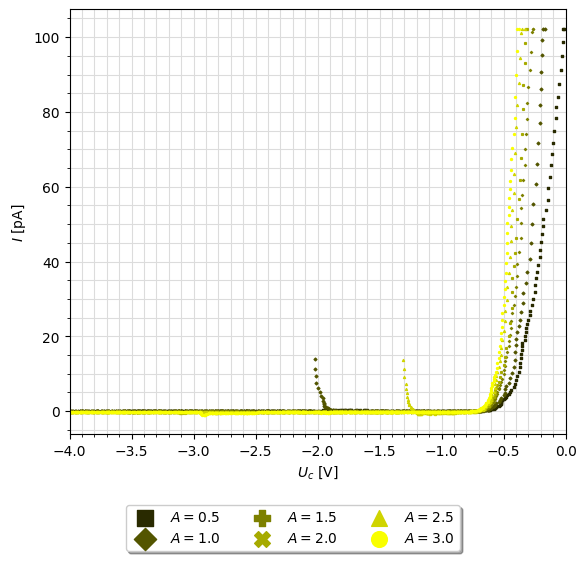

In [5]:
#@title Gráfica con apertura variable ($\lambda = 578 \text{ nm}$)
fig, ax = plt.subplots(layout='constrained')
for i in range(len(medida_lambda_578)):
  apertura = medida_lambda_578[i]['parametro_variable']
  ax.scatter(
    medida_lambda_578[i]['U_c'],
    medida_lambda_578[i]['I'],
    marker=markers[i],
    s=2,
    #lw=.4,
    fc=colores_lambda_578[i],
    #ec=edgec_lambda_578[i],
    zorder=2,
    label=f'$A = {apertura:.1f}$'
  )
ax.grid(True, which='both', color='gainsboro')
ax.minorticks_on()
ax.set_xlabel('$U_c$ [V]')
ax.set_ylabel('$I$ [pA]')
ax.set_xlim([-4, 0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3, markerscale=8)

Como se puede observar para las curvas correspondientes a una apertura de $A = 1.0$ y $A = 2.5$ se registraron picos de corriente posiblemente por inducción externa dada la escala de la corriente medida.

Text(0.055, 0.64, '$I$ [pA]')

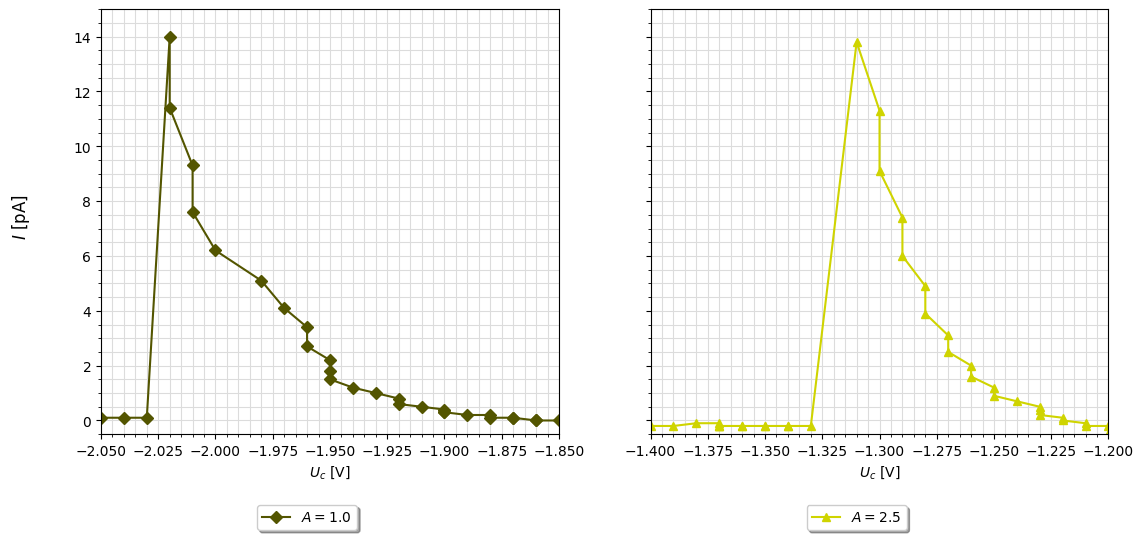

In [6]:
#@title Gráfica de los picos con $\lambda = 578 \text{ nm}$ contante y $A = 1.0, \; 2.5$
fig, axs = plt.subplots(1, 2, figsize=(13, 4.8), layout='constrained', sharey=True)

apertura_1 = medida_lambda_578[1]['parametro_variable']
axs[0].plot(
  medida_lambda_578[1]['U_c'],
  medida_lambda_578[1]['I'],
  marker=markers[1],
  ms=6,
  c=colores_lambda_578[1],
  zorder=2,
  label=f'$A = {apertura_1:.1f}$'
)
axs[0].grid(True, which='both', color='gainsboro')
axs[0].minorticks_on()
axs[0].set_xlabel('$U_c$ [V]')
axs[0].set_xlim([-2.05, -1.85])
axs[0].set_ylim([-0.5, 15])
box_1 = axs[0].get_position()
axs[0].set_position([box_1.x0, box_1.y0 + box_1.height * 0.1, box_1.width, box_1.height * 1.15])
axs[0].legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3)

apertura_4 = medida_lambda_578[4]['parametro_variable']
axs[1].plot(
  medida_lambda_578[4]['U_c'],
  medida_lambda_578[4]['I'],
  marker=markers[4],
  ms=6,
  c=colores_lambda_578[4],
  zorder=2,
  label=f'$A = {apertura_4:.1f}$'
)
axs[1].grid(True, which='both', color='gainsboro')
axs[1].minorticks_on()
axs[1].set_xlabel('$U_c$ [V]')
axs[1].set_xlim([-1.4, -1.2])
axs[1].set_ylim([-0.5, 15])
box_2 = axs[1].get_position()
axs[1].set_position([box_2.x0, box_2.y0 + box_2.height * 0.1, box_2.width, box_2.height * 1.15])
axs[1].legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3)

fig.supylabel('$I$ [pA]', x=0.055, y=0.64)

Con tal de solucionar esto, se va a utilizar un método de [medidas de escala robustas](https://es.wikipedia.org/wiki/Medidas_de_escala_robustas). Este método se basa en tomar los datos que se encuentran en un rango de percentiles simétrico respecto al $50\%$, los rangos más comunes son el rango del $25\%$ al $75\%$ ([IQR](https://en.wikipedia.org/wiki/Interquartile_range)) y el rango del $10\%$ al $90\%$ (IDR), sin embargo, dado que la cantidad de datos dentro de los picos es bastante pequeña entonces se usará el rango del $7\%$ al $93\%$ que es [similar a tomar los valores a una distancia de $1.5$ veces la desviación estándar respecto a la media de una distribución normal](https://en.wikipedia.org/wiki/Interdecile_range).

Se decide usar este tipo de métodos sobre las medidas convencionales de escala dado que estos últimos, al involucrar la desviación estándar, el estimador principal tiene un sesgo estadístico porque esta dispersión toma en cuenta información de los datos que no deberían estar, es decir, eliminar los datos por encima de $1.5$ veces la desviación estándar no va a reproducir el comportamiento ideal dado que la desviación estándar va a ser más grande de lo que debería ser si no estuvieran estos datos.

In [7]:
#@title Procesamiento de los picos por rango de percentiles ($7\%$ a $93\%$)
V_lim_1 = -0.85
I_1 = medida_lambda_578[1]['I']
mask_1 = medida_lambda_578[1]['U_c'] <= V_lim_1
I_1_const = I_1[mask_1]
U_1_const = medida_lambda_578[1]['U_c'][mask_1]

V_lim_4 = -0.8
I_4 = medida_lambda_578[4]['I']
mask_4 = medida_lambda_578[4]['U_c'] <= V_lim_4
I_4_const = I_4[mask_4]
U_4_const = medida_lambda_578[4]['U_c'][mask_4]

trimmed_tail = .07

U_1_const, I_1_const = percentile_range((trimmed_tail, 1 - trimmed_tail), U_1_const, I_1_const)
medida_lambda_578[1]['U_c'] = np.append(U_1_const, medida_lambda_578[1]['U_c'][~mask_1])
medida_lambda_578[1]['I'] = np.append(I_1_const, I_1[~mask_1])

U_4_const, I_4_const = percentile_range((trimmed_tail, 1 - trimmed_tail), U_4_const, I_4_const)
medida_lambda_578[4]['U_c'] = np.append(U_4_const, medida_lambda_578[4]['U_c'][~mask_4])
medida_lambda_578[4]['I'] = np.append(I_4_const, I_4[~mask_4])

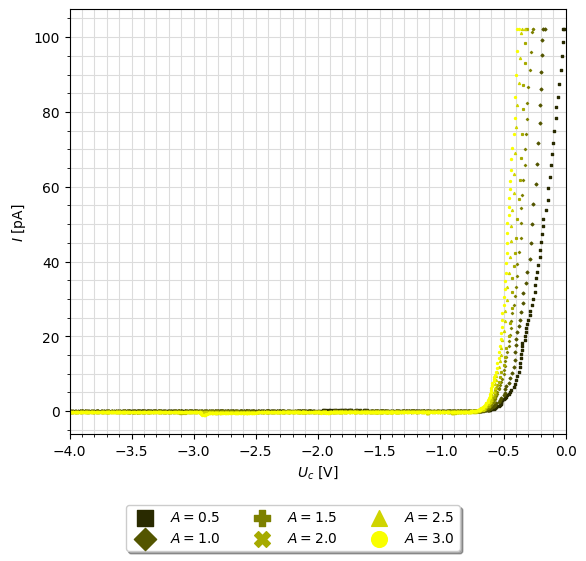

In [8]:
#@title Gráfica de los datos sin pico
fig, ax = plt.subplots(layout='constrained')
for i in range(len(medida_lambda_578)):
  apertura = medida_lambda_578[i]['parametro_variable']
  ax.scatter(
    medida_lambda_578[i]['U_c'],
    medida_lambda_578[i]['I'],
    marker=markers[i],
    s=2,
    #lw=.4,
    fc=colores_lambda_578[i],
    #ec=edgec_lambda_578[i],
    zorder=2,
    label=f'$A = {apertura:.1f}$'
  )
ax.grid(True, which='both', color='gainsboro')
ax.minorticks_on()
ax.set_xlabel('$U_c$ [V]')
ax.set_ylabel('$I$ [pA]')
ax.set_xlim([-4, 0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3, markerscale=8)

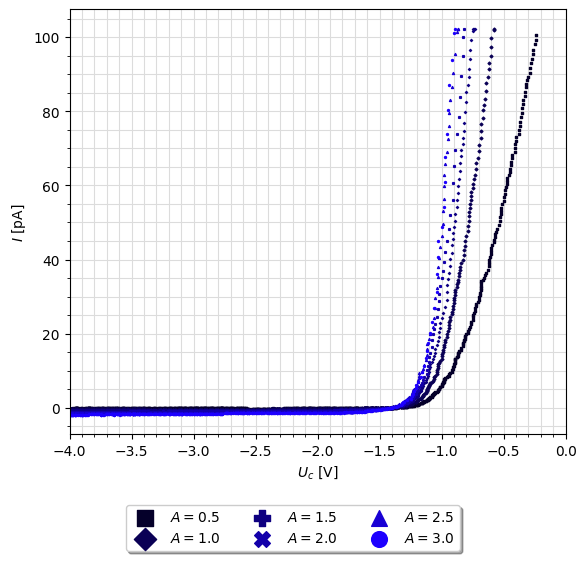

In [9]:
#@title Gráfica con apertura variable ($\lambda = 436 \text{ nm}$)
fig, ax = plt.subplots(layout='constrained')
for i in range(len(medida_lambda_436)):
  apertura = medida_lambda_436[i]['parametro_variable']
  ax.scatter(
    medida_lambda_436[i]['U_c'],
    medida_lambda_436[i]['I'],
    marker=markers[i],
    s=2,
    fc=colores_lambda_436[i],
    zorder=2,
    label=f'$A = {apertura:.1f}$'
  )
ax.grid(True, which='both', color='gainsboro')
ax.minorticks_on()
ax.set_xlabel('$U_c$ [V]')
ax.set_ylabel('$I$ [pA]')
ax.set_xlim([-4, 0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3, markerscale=8)

In [10]:
#@title Limpieza datos con apertura constante

# Ejecutar una única vez después de sacar los datos con data_from_file()
medida_apertura_1[0]['I'] = medida_apertura_1[0]['I'][:-2]
medida_apertura_1[0]['U_c'] = medida_apertura_1[0]['U_c'][:-2]

medida_apertura_1[1]['I'] = medida_apertura_1[1]['I'][:-16]
medida_apertura_1[1]['U_c'] = medida_apertura_1[1]['U_c'][:-16]

medida_apertura_1[3]['I'] = medida_apertura_1[3]['I'][:-2]
medida_apertura_1[3]['U_c'] = medida_apertura_1[3]['U_c'][:-2]

medida_apertura_1[4]['I'] = medida_apertura_1[4]['I'][:-2]
medida_apertura_1[4]['U_c'] = medida_apertura_1[4]['U_c'][:-2]

<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-496189140.py:12: SyntaxWarning: invalid escape sequence '\l'
  label=f'$\lambda = {apertura}$ nm'


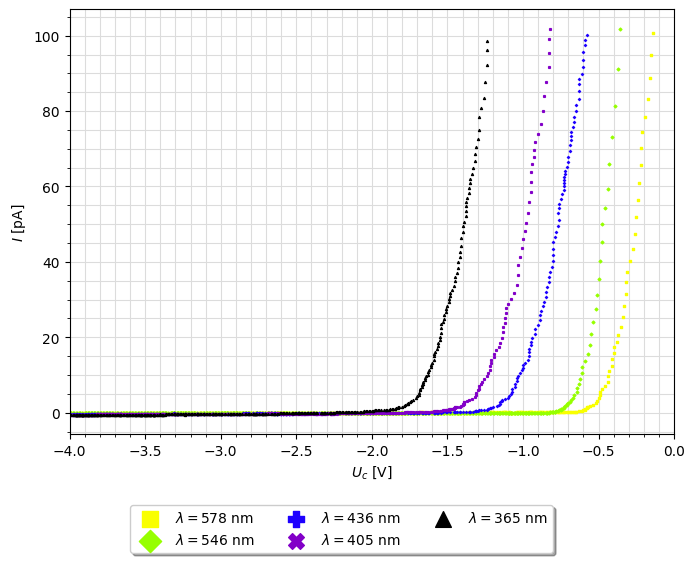

In [11]:
#@title Gráfica variando filtros ($A = 1 \text{ u.a.l.}$)
fig, ax = plt.subplots(figsize=(7.8, 4.8), layout='constrained')
for i in range(len(medida_apertura_1)):
  apertura = medida_apertura_1[i]['parametro_variable']
  ax.scatter(
    medida_apertura_1[i]['U_c'],
    medida_apertura_1[i]['I'],
    marker=markers[i],
    s=2,
    fc=colores_apertura_1[i],
    zorder=2,
    label=f'$\lambda = {apertura}$ nm'
  )
ax.grid(True, which='both', color='gainsboro')
ax.minorticks_on()
ax.set_xlabel('$U_c$ [V]')
ax.set_ylabel('$I$ [pA]')
ax.set_xlim([-4, 0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3, markerscale=8)

## Voltaje de frenado teórico $U_0$

Energía cinética de un electrón que **superó** la función trabajo del Potasio
$$
E_\text{kin} = \frac{h c}{\lambda} - \phi_\text{K}
$$

Energía total de un electrón que **salió** del ánodo
$$
E = E_\text{kin} - e U_c = \frac{h c}{\lambda} - \phi_\text{K} - e U_c
$$

De la primera ecuación, por definición se sabe que $E_\text{kin} \geq 0$, y como $\lambda \geq 0$, entonces esta debe cumplir la siguiente relación

$$
\frac{h c}{\lambda} - \phi_\text{K} \geq 0 \Longleftrightarrow \frac{h c}{\phi_\text{K}} \geq \lambda
$$

De donde, la longitud de onda máxima (o frecuencia mínima) para la que se cumple esta desigualdad es
$$
\boxed{\lambda_\text{umbral} = \frac{h c}{\phi_\text{K}}}
$$

que sería la longitud de onda umbral (en nuestro caso del potasio).

De la segunda ecuación, dado que la energía cinética es positiva, si $E < 0$ esto indicaría que el potencial retardador fue mayor a la energía cinética con la que fue expulsado el fotoelectrón y por ende **no llega al ánodo**.
En cambio, si $E > 0$ indica que la energía cinética del fotoelectrón fue mayor y por ende **fue detectado en el ánodo**.

En el caso que $E = 0$ el voltaje $U$ es el justo para que lleguen electrones, pero si llega a haber un efecto mínimo sobre la energía del sistema (el sistema en la práctica no es ideal), lo más seguro es que no alcance a llegar.

Con $E = 0$, el valor del voltaje es el voltaje de frenado $U_0$
$$
\frac{h c}{\lambda} - \phi_\text{K} - e U_0 = 0 \Longleftrightarrow \boxed{U_0 = \frac{1}{e} \left(\frac{hc}{\lambda} - \phi_\text{K}\right)}
$$

Dado que $h$, $c$ y $e$ tienen valores exactos, suponiendo $\Delta \phi_\text{K} = 0.01 \text{ eV}$ y tomando $\Delta \lambda = 2 \text{ nm}$; se tiene que el error propagado para los voltajes de frenado teóricos es:
$$
\boxed{\Delta U_0 = \frac{1}{e} \sqrt{\left(\frac{hc}{\lambda^2} \Delta \lambda\right)^2 + \left(\Delta \phi_\text{K}\right)^2}}
$$

In [12]:
def voltaje_frenado_teorico(longitud_de_onda):
  """
  Parametros:
  longitud de onda (float or array): en nanometros

  Returns:
  voltaje de frenado (float or array): en voltios
  """


  phi_K = 2.29  # [eV]: CRC Handbook of Chemistry and Physics version 2008, p. 12–124.
  Delta_phi_K = 0.01  # [eV]
  Delta_lambda = 2  # [nm]

  h = 6.62607015e-34  # [J s]
  c = 299792458  # [m/s]
  e = 1.602176634e-19  # [C * V] : (e [C]) * (1 [V])
  h_c = 1e+9 * h * c / e  # [neV] : 1e+9 pasa los metros a nanómetros (unidades de λ)

  longitud_umbral = h_c / phi_K  # [nm]
  Delta_longitud_umbral = longitud_umbral * Delta_phi_K / phi_K

  V_frenado = ((h_c / longitud_de_onda) - phi_K)# / e
  V_frenado[V_frenado < 0] = 0
  Delta_V_frenado = np.sqrt((h_c * Delta_lambda / np.power(longitud_de_onda, 2))**2 + (Delta_phi_K)**2)# / e

  return V_frenado, Delta_V_frenado, longitud_umbral, Delta_longitud_umbral



In [13]:
#@title Tabla de voltajes de frenado teóricos
longitudes_de_onda = np.array([365,405,436,546,578])
V_frenado, Delta_V_frenado, longitud_umbral, Delta_longitud_umbral = voltaje_frenado_teorico(longitudes_de_onda)

print(f'Longitud de onda mínima teórica: ({longitud_umbral:.0f} ± {Delta_longitud_umbral:.0f}) nm')
df = pd.DataFrame({
    'λ [±2 nm]': longitudes_de_onda,
    'V₀ (teórico) [V]': -V_frenado,
    'ΔV₀ [V]': Delta_V_frenado,
})
df.set_index('λ [±2 nm]', inplace=True)
display(df)

Longitud de onda mínima teórica: (541 ± 2) nm


,V₀ (teórico) [V],ΔV₀ [V]
λ [±2 nm],,
365,-1.106827,0.021129
405,-0.771338,0.018126
436,-0.553674,0.016436
546,-0.000000,0.013007
578,-0.000000,0.012454


# Métodos para determinar el voltaje de frenado $U_0$

## Método 1: Valor promedio de la región sin corriente fotoeléctrica

En este caso, se graficó el error estándar acumulado de la corriente para cada medida hasta un voltaje límite arbitrario y se tomó el último mínimo local como el límite del rango en donde se sacará el promedio.

Con esto mínimos se determinarían los rangos de voltaje donde la desviación de la corriente aumenta, es decir, los voltajes a partir de donde la corriente se empieza a desviar de los promedios anteriores.

Se decidió usar el error estándar (SEM) y no la desviación estándar dado que este primero decrece a medida que el número de datos aumenta $\left(\sigma_{\bar{X}} \propto N^{-1/2}\right)$, por lo que, si los valores de corriente que se añadan a un rango inicial se mantienen dentro de este, entonces el error estándar va a decrecer indicando que el promedio de la corriente es cada vez más preciso.

Con este valor promedio de la corriente dentro del rango con el último mínimo local, se le van a añadir unos pocos $\text{pA}$ ($\sim 2 \text{ pA}$ según la última gráfica de la página 4 de la guía) y se hallará el valor del voltaje correspondiente al valor medido de la corriente más cercano a este promedio $+2 \text{ pA}$.

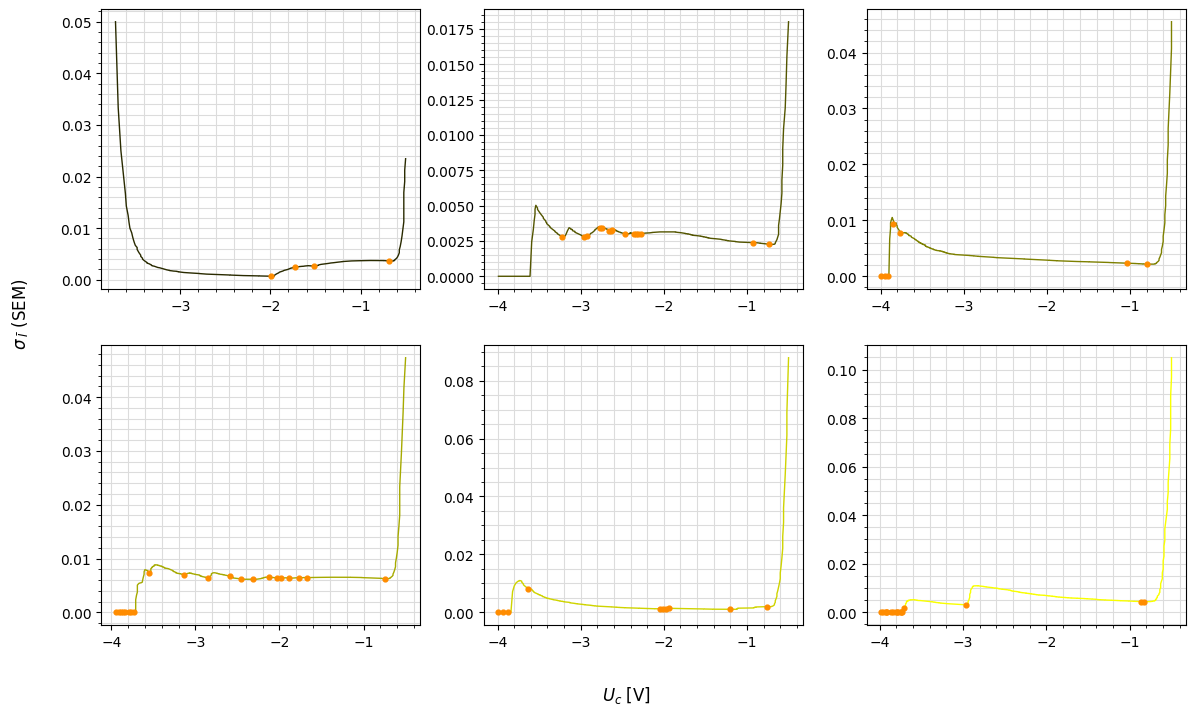

In [14]:
mins_lambda_578 = mins_locales_SEM(medida_lambda_578, -0.5, colores_lambda_578)

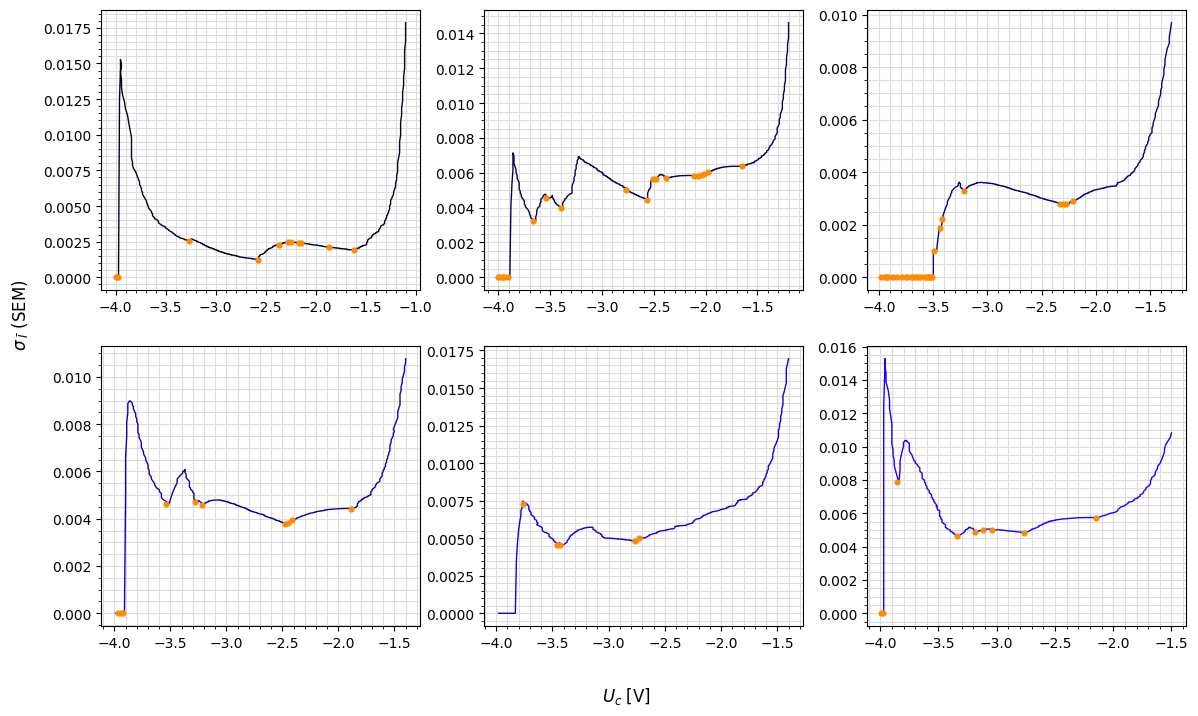

In [15]:
mins_lambda_436 = mins_locales_SEM(medida_lambda_436, [-1.1, -1.2, -1.3, -1.4, -1.4, -1.5], colores_lambda_436)

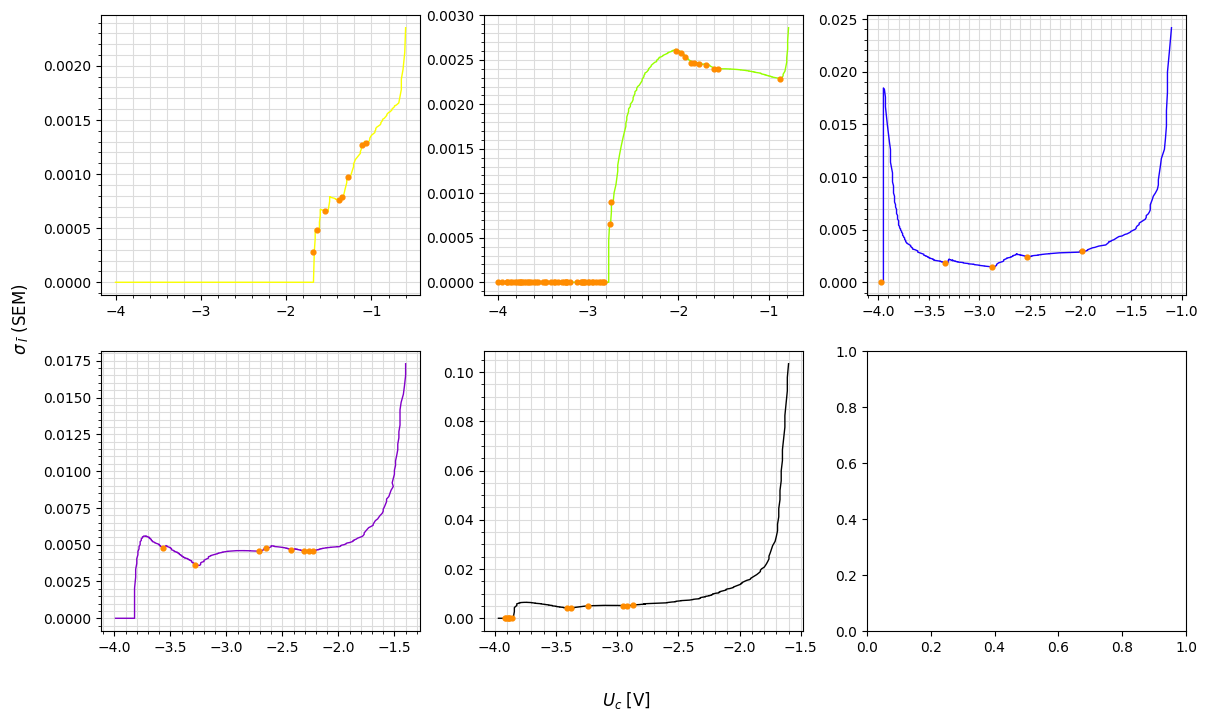

In [16]:
mins_apertura_1 = mins_locales_SEM(medida_apertura_1, [-0.6, -0.78, -1.1, -1.4, -1.6], colores_apertura_1)

In [17]:
def voltaje_frenado_1(medida, indices_mins):
  last_mins = np.array([inds[-1] for inds in indices_mins], dtype=np.uint16)
  I_p = np.empty(len(medida))
  Delta_I_p = np.empty(len(medida))
  V_p = np.empty(len(medida))
  V_m = np.empty(len(medida))
  offset = 2  # [pA]

  for i in range(len(medida)):
    I_mean = np.mean(medida[i]['I'][:last_mins[i]])
    error = np.sqrt((np.std(medida[i]['I'][:last_mins[i]], ddof=1)/np.sqrt(last_mins[i]))**2 + (I_mean*0.01 + 300*0.005)**2)
    I_upper = I_mean + error + offset
    I_under = I_mean - error + offset
    ind_p = (np.abs(medida[i]['I'] - I_upper)).argmin()
    ind_m = (np.abs(medida[i]['I'] - I_under)).argmin()
    V_p[i] = medida[i]['U_c'][ind_p]
    V_m[i] = medida[i]['U_c'][ind_m]
    I_p[i] = I_mean
    Delta_I_p[i] = error

  V_0 = (V_p + V_m)/2
  Delta_V_0 = (V_p - V_m)/2

  return V_0, Delta_V_0, I_p, Delta_I_p



In [18]:
V_0_578_1, Delta_V_0_578_1, I_p_578, Delta_I_p_578 = voltaje_frenado_1(medida_lambda_578, mins_lambda_578)
V_0_436_1, Delta_V_0_436_1, I_p_436, Delta_I_p_436 = voltaje_frenado_1(medida_lambda_436, mins_lambda_436)
V_0_A1_1, Delta_V_0_A1_1, I_p_A1, Delta_I_p_A1 = voltaje_frenado_1(medida_apertura_1, mins_apertura_1)

prom_V_0_578 = np.mean(V_0_578_1)
inct_V_0_578_1 = np.sqrt((np.mean(Delta_V_0_578_1))**2 + (np.var(V_0_578_1, ddof=1)/5)*(t.ppf(.975, 5)**2))
prom_V_0_436 = np.mean(V_0_436_1)
inct_V_0_436_1 = np.sqrt((np.mean(Delta_V_0_436_1))**2 + (np.var(V_0_436_1, ddof=1)/5)*(t.ppf(.975, 5)**2))

df = pd.DataFrame({
    'λ [nm]': [medida['parametro_variable'] for medida in medida_apertura_1],
    'V₀ [V]': V_0_A1_1,
    'ΔV₀ [V]': Delta_V_0_A1_1,
})
df.set_index('λ [nm]', inplace=True)

print('Voltajes de frenado calculados del método 1')
print('===========================================')
print(f'Para λ = 578 nm, el voltaje de frenado fue: V₀ = ({prom_V_0_578:.2f} ± {inct_V_0_578_1:.2f}) V')
print(f'Para λ = 436 nm, el voltaje de frenado fue: V₀ = ({prom_V_0_436:.1f} ± {inct_V_0_436_1:.1f}) V')
print(f'\nCon una apertura = 1 constante:')
display(df)

Voltajes de frenado calculados del método 1
Para λ = 578 nm, el voltaje de frenado fue: V₀ = (-0.61 ± 0.07) V
Para λ = 436 nm, el voltaje de frenado fue: V₀ = (-1.4 ± 0.2) V

Con una apertura = 1 constante:


,V₀ [V],ΔV₀ [V]
λ [nm],,
578,-0.560,0.050
546,-0.735,0.055
436,-1.295,0.155
405,-1.575,0.205
365,-2.035,0.295


## Método 2: Intersección de rectas

Para este método se usó la misma corriente promedio del método anterior y luego se determinó la región de corriente fotoeléctrica donde existía la mejor correlación lineal entre $I_p$ y $U_c$.

Con estas dos regiones, se pueden determinar dos rectas en cada curva corriente-voltaje:
-  Una horizontal donde la corriente se mantiene constante dentro del último intervalo de confianza más pequeño (la recta promedio del método anterior)
-  Una recta que se ajusta de la mejor manera a la región lineal de la corriente fotoeléctrica medidia (fuera de la región de transición de corriente fotoeléctrica).

La absica de la intersección de estas dos rectas correspondería en este caso al valor del voltaje de frenado.

-  Recta 1: $y = I_p$
-  Recta 2: $y = m U_0 + b$

Igualando ambas ecuaciones:
$$
I_p = m U_0 + b \Longleftrightarrow \boxed{U_0 = \frac{I_p - b}{m}}
$$

Error propagado de este error:
$$
\Delta U_0 = \sqrt{\left(\frac{\Delta I_p}{m}\right)^2 + \left(\frac{\Delta b}{m}\right)^2 + \left(\frac{I_p - b}{m^2} \Delta m\right)^2} = \frac{1}{m} \sqrt{\left(\Delta I_p\right)^2 + \left(\Delta b\right)^2 + \left(U_0 \Delta m\right)^2}
$$

In [19]:
from scipy import stats
from scipy.optimize import curve_fit

urls = {
    'apertura_1': 'https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Efecto%20fotoel%C3%A9ctrico/apertura_1.csv',
    'lambda_578': 'https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Efecto%20fotoel%C3%A9ctrico/lambda_578.csv',
    'lambda_436': 'https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Efecto%20fotoel%C3%A9ctrico/lambda_436.csv'
}

datos = {}
for nombre, url in urls.items():
    df = pd.read_csv(url, delimiter=';')
    datos[nombre] = df
    print(f"\n{nombre}:")
    print(f"  Columnas: {df.columns.tolist()}")
    print(f"  Forma: {df.shape}")
    print(df.head(3))




apertura_1:
  Columnas: ['lambda', '578', 'lambda.1', '546', 'lambda.2', '436', 'lambda.3', '405', 'lambda.4', '365']
  Forma: (544, 10)
       lambda       578    lambda.1       546    lambda.2       436  \
0  U_B1#1 / V  I#1 / pA  U_B1#2 / V  I#2 / pA  U_B1#3 / V  I#3 / pA   
1          -4         0          -4      -0.2       -3.99      -0.4   
2          -4         0       -3.99      -0.2       -3.98      -0.4   

     lambda.3       405    lambda.4       365  
0  U_B1#4 / V  I#4 / pA  U_B1#5 / V  I#5 / pA  
1          -4      -0.5       -3.99      -0.6  
2          -4      -0.5       -3.98      -0.6  

lambda_578:
  Columnas: ['Apertura', '0.5', 'Apertura.1', '1', 'Apertura.2', '1.5', 'Apertura.3', '2', 'Apertura.4', '2.5', 'Apertura.5', '3']
  Forma: (717, 12)
     Apertura       0.5  Apertura.1         1  Apertura.2       1.5  \
0  U_B1#1 / V  I#1 / pA  U_B1#2 / V  I#2 / pA  U_B1#3 / V  I#3 / pA   
1       -3.78         0          -4         0       -3.99      -0.1   
2       -

In [20]:
def mejor_ajuste(voltaje, corriente, nombre_curva, num_puntos_min=5, num_puntos_max=20):
    """
    Prueba diferentes rangos en la región de altas corrientes y
    selecciona el que tenga el mejor R²

    Parámetros:
    - voltaje: array de voltajes
    - corriente: array de corrientes
    - nombre_curva: nombre para identificar la curva
    - num_puntos_min: mínimo número de puntos para el ajuste
    - num_puntos_max: máximo número de puntos para el ajuste
    """
    idx_sort = np.argsort(voltaje)
    v_sorted = voltaje[idx_sort]
    i_sorted = corriente[idx_sort]

    mejor_r2 = -np.inf
    mejor_ajuste = None
    mejor_num_puntos = 0

    for n_puntos in range(num_puntos_min, min(num_puntos_max+1, len(v_sorted))):
      v_region = v_sorted[-n_puntos:]
      i_region = i_sorted[-n_puntos:]

      pendiente, intercepto, r_value, p_value, std_err = stats.linregress(v_region, i_region)
      r2 = r_value ** 2

      if r2 > mejor_r2:
        mejor_r2 = r2
        mejor_ajuste = {
            'pendiente': pendiente,
            'intercepto': intercepto,
            'r2': r2,
            'std_err': std_err,
            'p_value': p_value,
            'v_region': v_region,
            'i_region': i_region,
            'v_min': v_region.min(),
            'v_max': v_region.max()
        }
        mejor_num_puntos = n_puntos
    v_parado = -mejor_ajuste['intercepto'] / mejor_ajuste['pendiente']
    mejor_ajuste['v_parado'] = v_parado
    mejor_ajuste['num_puntos'] = mejor_num_puntos

    return mejor_ajuste, v_sorted, i_sorted

Graficas

In [35]:
def graficar_analisis(voltaje, corriente, ajuste, nombre_curva):
    """
    Grafica la curva I-V con el mejor ajuste lineal
    """
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))

    # Gráfico completo
    ax = axes[0]
    ax.plot(voltaje, corriente, 'k.-', markersize=4, alpha=0.6, label='Datos experimentales')
    ax.plot(ajuste['v_region'], ajuste['i_region'], 'r.', markersize=7,
            label=f'Región ajuste ({ajuste["num_puntos"]} puntos)')

    # Línea de ajuste extendida
    v_ext = np.linspace(ajuste['v_parado'] - 0.5, voltaje.max(), 100)
    i_ext = ajuste['pendiente'] * v_ext + ajuste['intercepto']
    ax.plot(v_ext, i_ext, 'r--', linewidth=1.5,
            label=f'Ajuste lineal (R²={ajuste["r2"]:.6f})')

    # Voltaje de parado
    ax.plot(ajuste['v_parado'], 0, 'g*', markersize=12,
            label=f'V_parado = {ajuste["v_parado"]:.4f} V')
    ax.axvline(ajuste['v_parado'], color='g', linestyle=':', alpha=0.5, linewidth=2)
    ax.axhline(0, color='gray', linestyle='-', alpha=0.3, linewidth=1)

    ax.set_xlabel('Voltaje (V)', fontsize=12)
    #ax.set_ylabel('Corriente (pA)', fontsize=12)
    ax.set_ylim([-20, 120])
    ax.set_title(f'{nombre_curva}\nCurva I-V Completa', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

    # Zoom en región de ajuste
    ax = axes[1]
    ax.plot(ajuste['v_region'], ajuste['i_region'], 'r.', markersize=8,
            label='Puntos de ajuste')
    v_fit = np.linspace(ajuste['v_min'], ajuste['v_max'], 100)
    i_fit = ajuste['pendiente'] * v_fit + ajuste['intercepto']
    ax.plot(v_fit, i_fit, 'r--', linewidth=1.5,
            label=f'y = {ajuste["pendiente"]:.2f}x + {ajuste["intercepto"]:.2f}')

    ax.set_xlabel('Voltaje (V)', fontsize=12)
    #ax.set_ylabel('Corriente (pA)', fontsize=12)
    ax.set_title(f'Zoom: Región de Altas Corrientes\nR² = {ajuste["r2"]:.6f}',
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

    # Zoom en voltaje de parado
    ax = axes[2]
    margen = 0.8
    idx_zoom = (voltaje >= ajuste['v_parado'] - margen) & (voltaje <= ajuste['v_parado'] + margen)
    ax.plot(voltaje[idx_zoom], corriente[idx_zoom], 'k.-', markersize=6, alpha=0.6)

    v_ext_zoom = np.linspace(ajuste['v_parado'] - margen, ajuste['v_parado'] + margen, 100)
    i_ext_zoom = ajuste['pendiente'] * v_ext_zoom + ajuste['intercepto']
    ax.plot(v_ext_zoom, i_ext_zoom, 'r--', linewidth=1.5, label='Extrapolación lineal')

    ax.plot(ajuste['v_parado'], 0, 'g*', markersize=12,
            label=f'V_parado = {ajuste["v_parado"]:.4f} V')
    ax.axvline(ajuste['v_parado'], color='g', linestyle=':', alpha=0.5, linewidth=2)
    ax.axhline(0, color='gray', linestyle='-', alpha=0.5, linewidth=2)

    ax.set_xlabel('Voltaje (V)', fontsize=12)
    ax.set_ylim([-20, 120])
    ax.set_title(f'Zoom: Voltaje de Parado', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

    fig.supylabel('Corriente (pA)', fontsize=12)
    plt.tight_layout()
    plt.show()




MEJOR AJUSTE ENCONTRADO para apertura_1_1:
  Número de puntos usados: 14
  Rango de voltaje: [-0.2900, -0.1400] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 410.599798 pA/V
  Intercepto (b): 156.328528 pA
  R²: 0.98399342
  Error estándar: 15.117548
  p-value: 3.82e-12

VOLTAJE DE PARADO:
  V_parado = -0.3807 V
  (Calculado como: -intercepto/pendiente)


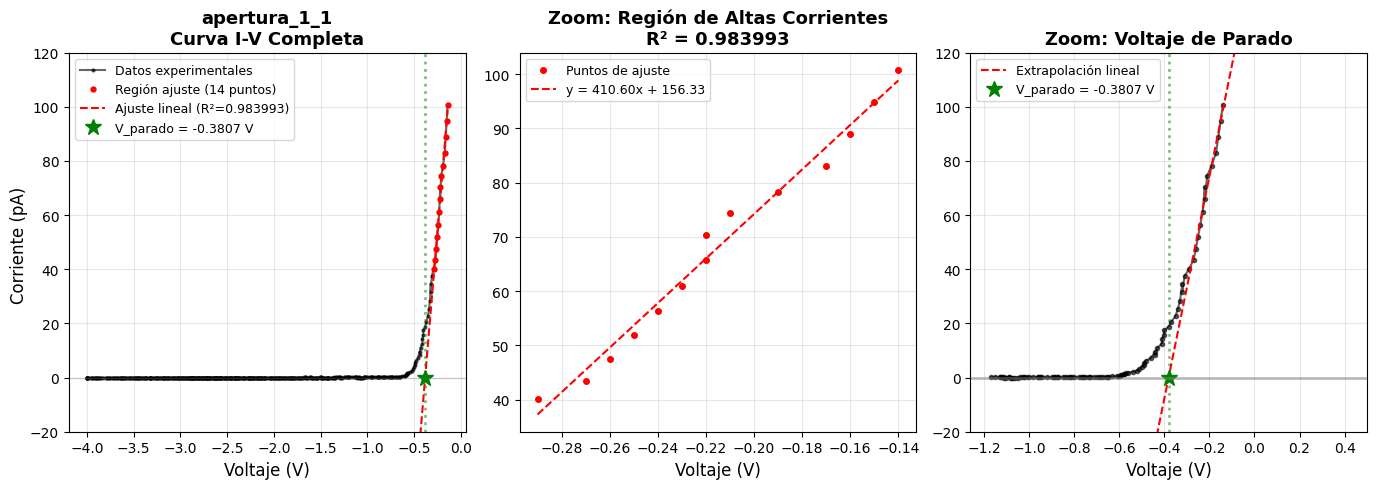


MEJOR AJUSTE ENCONTRADO para apertura_1_2:
  Número de puntos usados: 13
  Rango de voltaje: [-0.5200, -0.3600] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 433.070953 pA/V
  Intercepto (b): 252.725721 pA
  R²: 0.98854367
  Error estándar: 14.056834
  p-value: 4.99e-12

VOLTAJE DE PARADO:
  V_parado = -0.5836 V
  (Calculado como: -intercepto/pendiente)


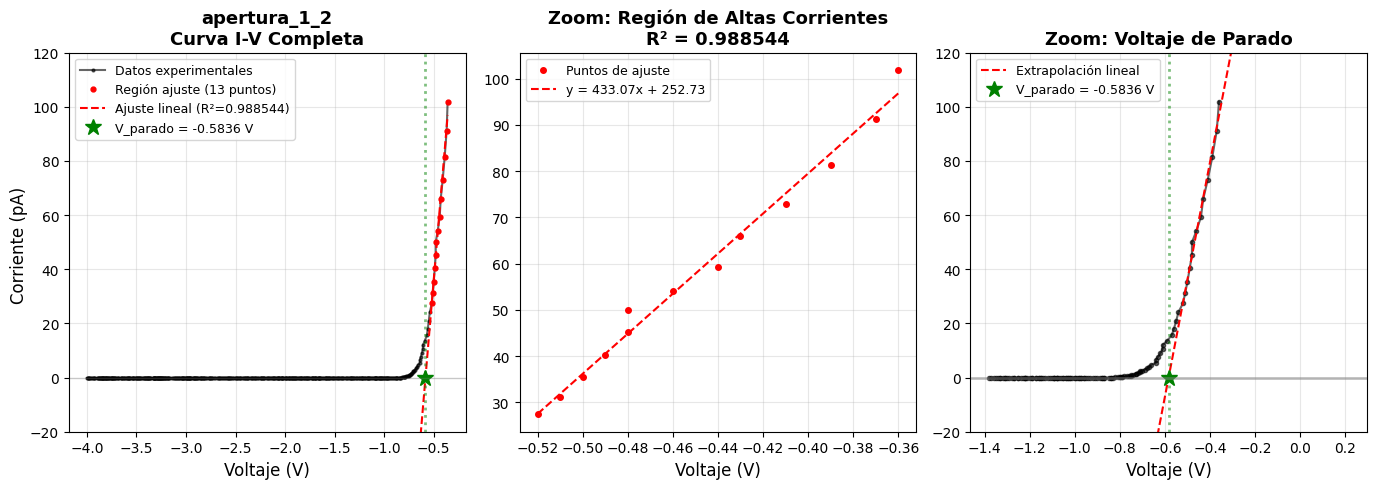


MEJOR AJUSTE ENCONTRADO para apertura_1_3:
  Número de puntos usados: 20
  Rango de voltaje: [-0.6900, -0.5800] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 268.274101 pA/V
  Intercepto (b): 255.198191 pA
  R²: 0.97765983
  Error estándar: 9.558546
  p-value: 2.60e-16

VOLTAJE DE PARADO:
  V_parado = -0.9513 V
  (Calculado como: -intercepto/pendiente)


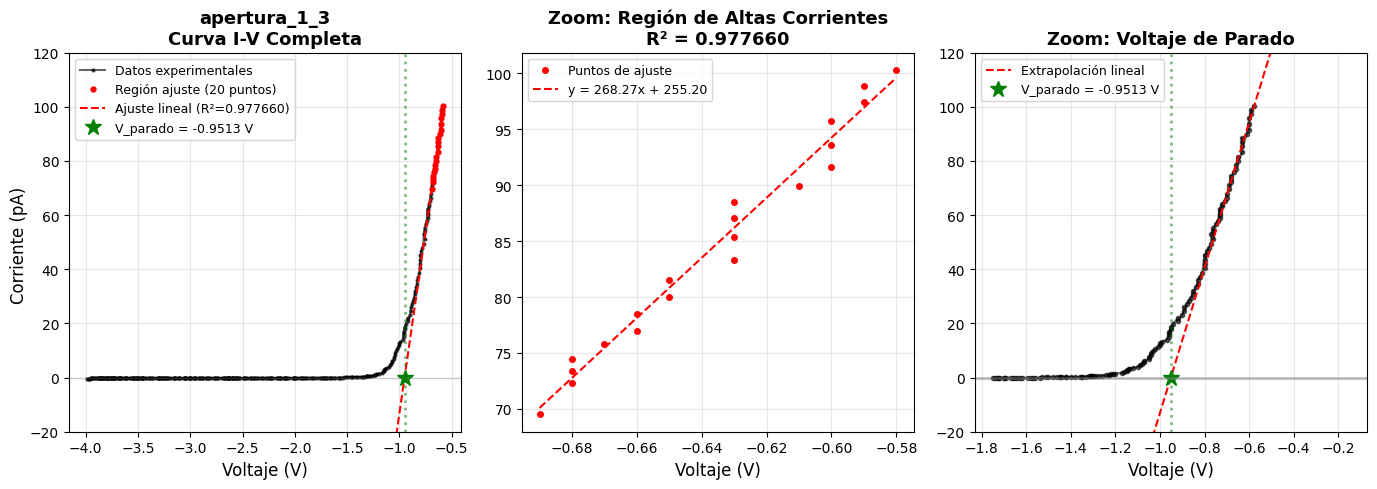


MEJOR AJUSTE ENCONTRADO para apertura_1_4:
  Número de puntos usados: 20
  Rango de voltaje: [-0.9900, -0.8200] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 288.248078 pA/V
  Intercepto (b): 334.241006 pA
  R²: 0.97361803
  Error estándar: 11.183803
  p-value: 1.16e-15

VOLTAJE DE PARADO:
  V_parado = -1.1596 V
  (Calculado como: -intercepto/pendiente)


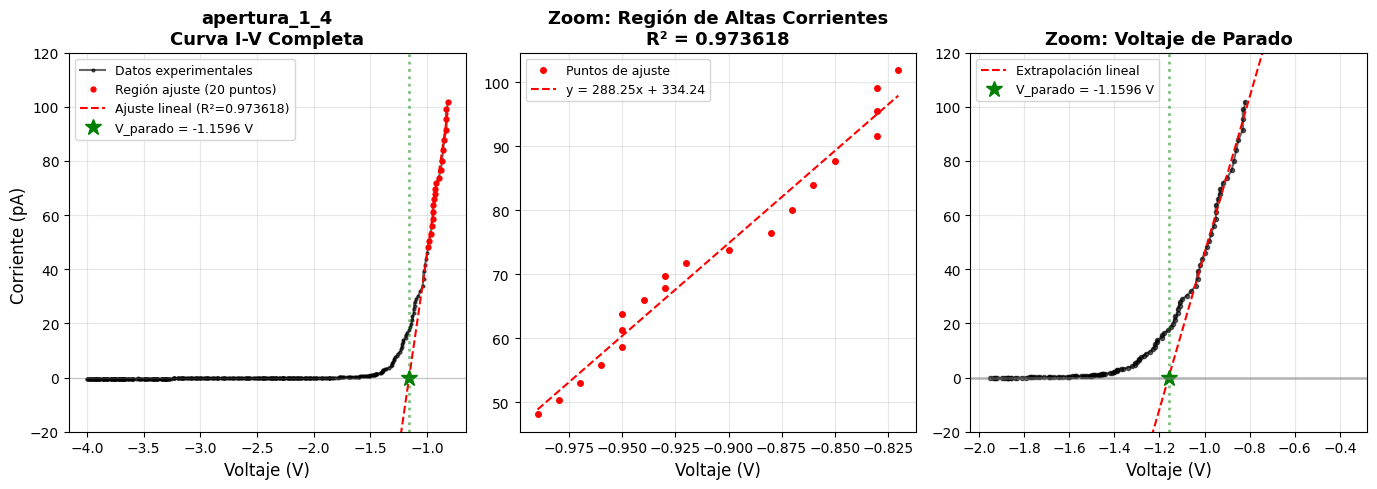


MEJOR AJUSTE ENCONTRADO para apertura_1_5:
  Número de puntos usados: 20
  Rango de voltaje: [-1.3800, -1.2400] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 291.336439 pA/V
  Intercepto (b): 453.824399 pA
  R²: 0.97099737
  Error estándar: 11.867745
  p-value: 2.73e-15

VOLTAJE DE PARADO:
  V_parado = -1.5577 V
  (Calculado como: -intercepto/pendiente)


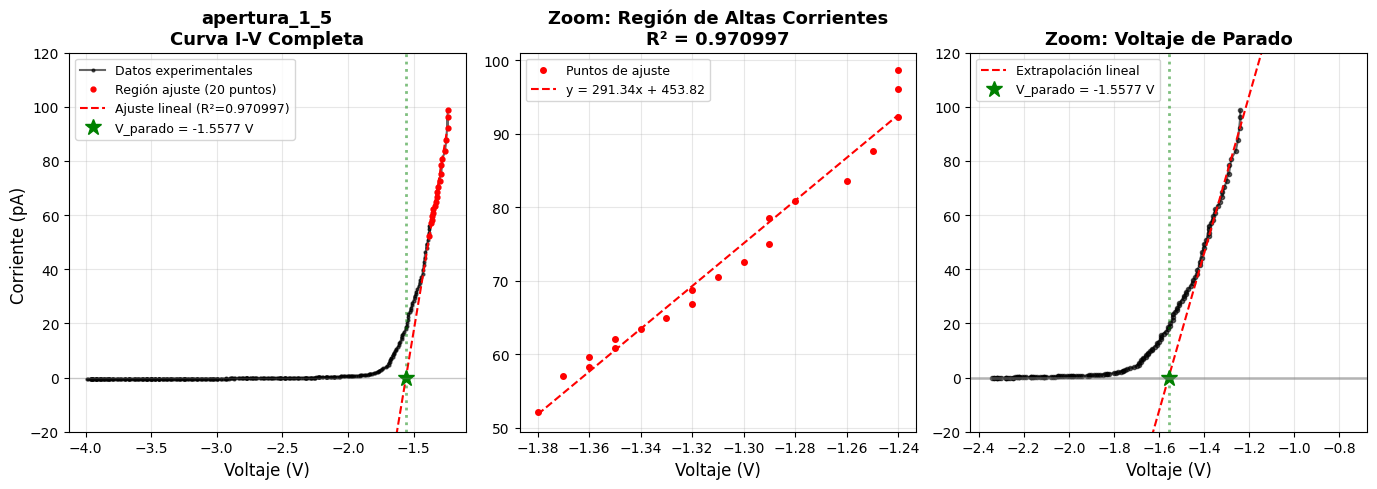


MEJOR AJUSTE ENCONTRADO para lambda_578_1:
  Número de puntos usados: 17
  Rango de voltaje: [-0.1600, -0.0100] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 334.367964 pA/V
  Intercepto (b): 105.642811 pA
  R²: 0.99200447
  Error estándar: 7.750786
  p-value: 3.80e-17

VOLTAJE DE PARADO:
  V_parado = -0.3159 V
  (Calculado como: -intercepto/pendiente)


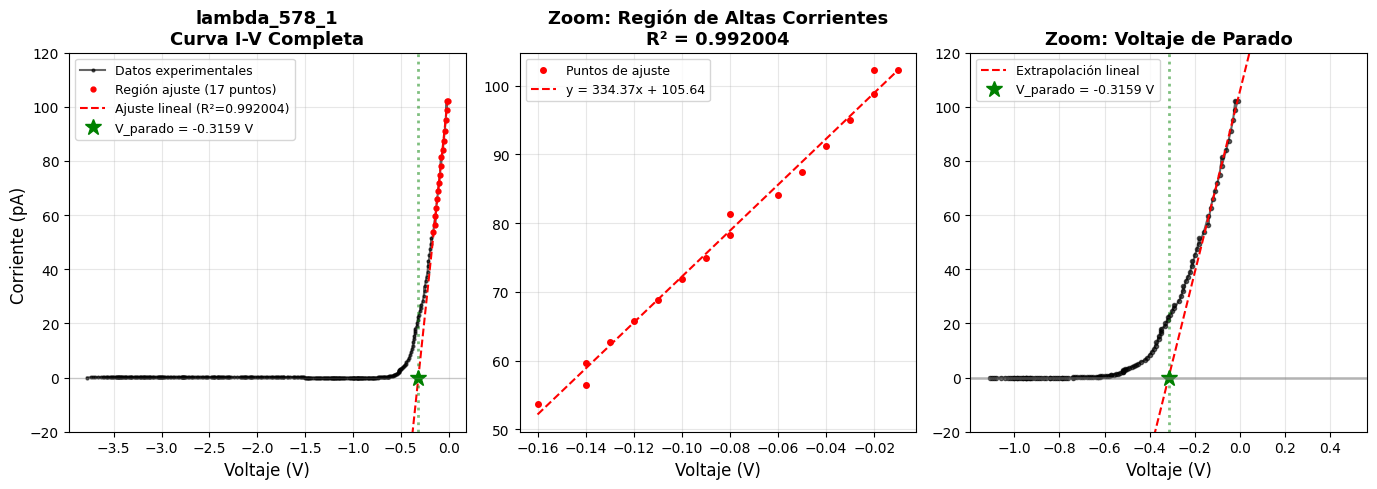


MEJOR AJUSTE ENCONTRADO para lambda_578_2:
  Número de puntos usados: 15
  Rango de voltaje: [-0.2900, -0.1700] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 553.357909 pA/V
  Intercepto (b): 198.167694 pA
  R²: 0.97182536
  Error estándar: 26.131811
  p-value: 1.85e-11

VOLTAJE DE PARADO:
  V_parado = -0.3581 V
  (Calculado como: -intercepto/pendiente)


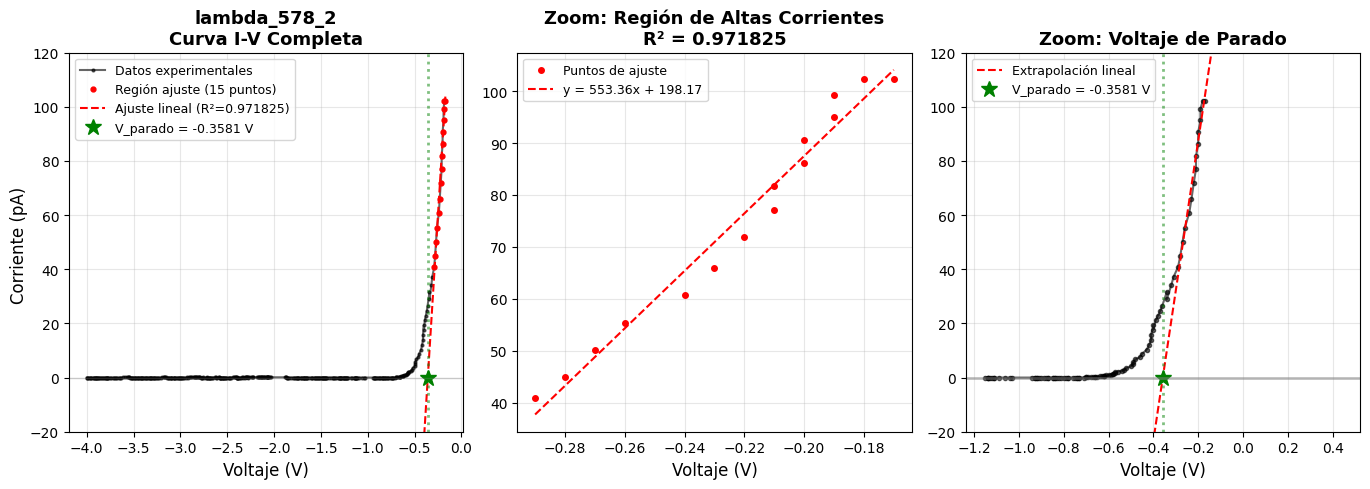


MEJOR AJUSTE ENCONTRADO para lambda_578_3:
  Número de puntos usados: 20
  Rango de voltaje: [-0.4000, -0.2600] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 523.822618 pA/V
  Intercepto (b): 241.179553 pA
  R²: 0.98900373
  Error estándar: 13.018820
  p-value: 4.38e-19

VOLTAJE DE PARADO:
  V_parado = -0.4604 V
  (Calculado como: -intercepto/pendiente)


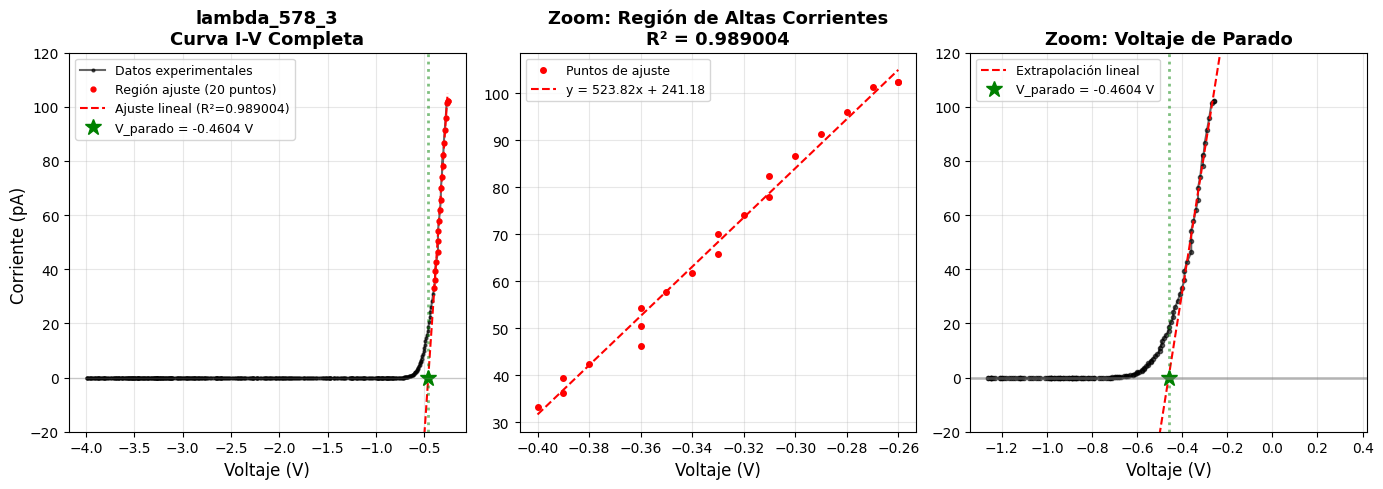


MEJOR AJUSTE ENCONTRADO para lambda_578_4:
  Número de puntos usados: 18
  Rango de voltaje: [-0.4500, -0.3100] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 599.447127 pA/V
  Intercepto (b): 288.480333 pA
  R²: 0.97685387
  Error estándar: 23.068285
  p-value: 1.63e-14

VOLTAJE DE PARADO:
  V_parado = -0.4812 V
  (Calculado como: -intercepto/pendiente)


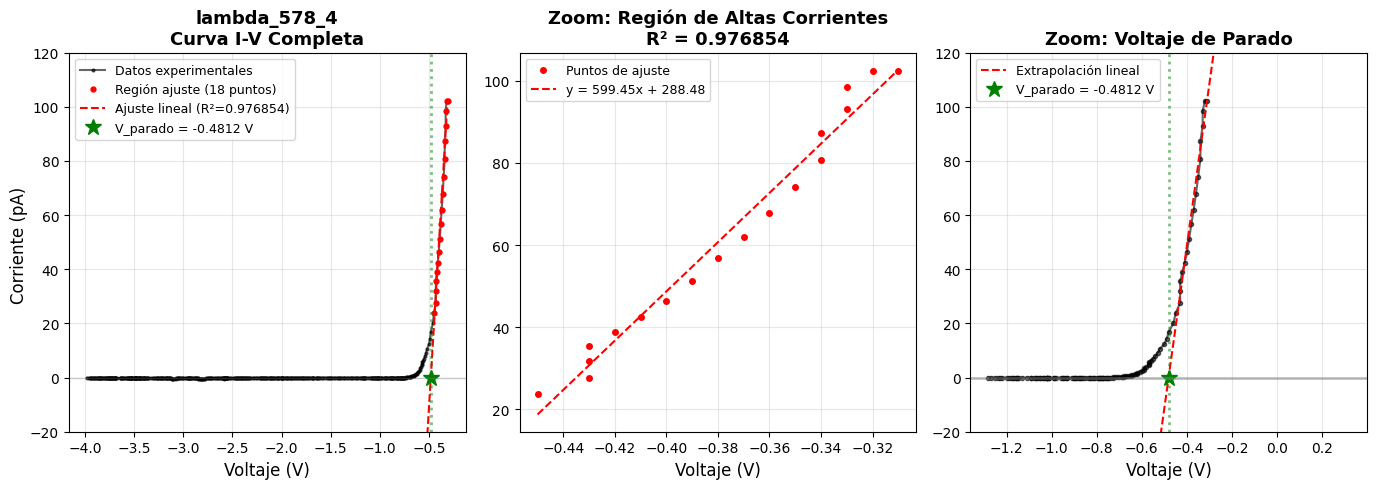


MEJOR AJUSTE ENCONTRADO para lambda_578_5:
  Número de puntos usados: 20
  Rango de voltaje: [-0.5000, -0.3300] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 558.213325 pA/V
  Intercepto (b): 296.343343 pA
  R²: 0.97868850
  Error estándar: 19.415505
  p-value: 1.70e-16

VOLTAJE DE PARADO:
  V_parado = -0.5309 V
  (Calculado como: -intercepto/pendiente)


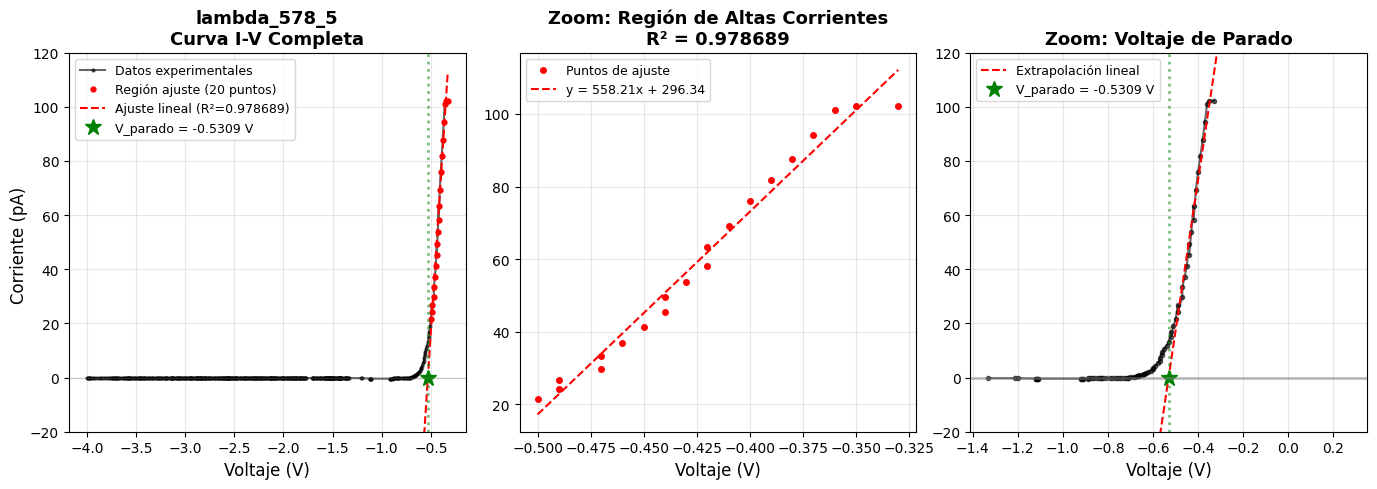


MEJOR AJUSTE ENCONTRADO para lambda_578_6:
  Número de puntos usados: 20
  Rango de voltaje: [-0.4800, -0.3800] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 624.281950 pA/V
  Intercepto (b): 339.928353 pA
  R²: 0.97941315
  Error estándar: 21.333223
  p-value: 1.24e-16

VOLTAJE DE PARADO:
  V_parado = -0.5445 V
  (Calculado como: -intercepto/pendiente)


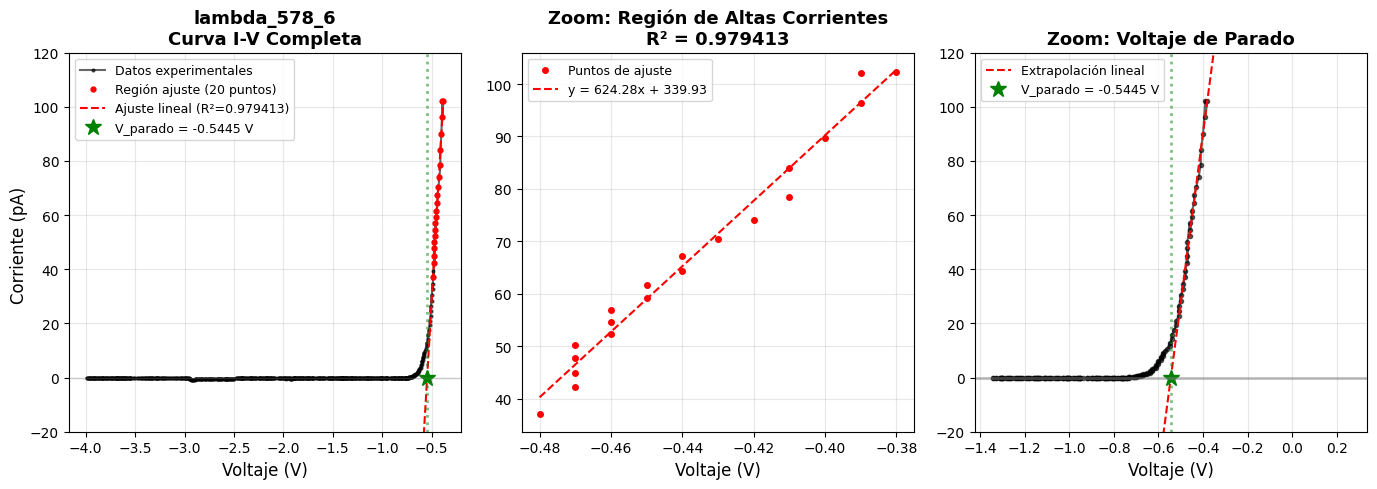


MEJOR AJUSTE ENCONTRADO para lambda_436_1:
  Número de puntos usados: 20
  Rango de voltaje: [-0.3600, -0.2400] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 172.758621 pA/V
  Intercepto (b): 141.251724 pA
  R²: 0.98934775
  Error estándar: 4.225223
  p-value: 3.29e-19

VOLTAJE DE PARADO:
  V_parado = -0.8176 V
  (Calculado como: -intercepto/pendiente)


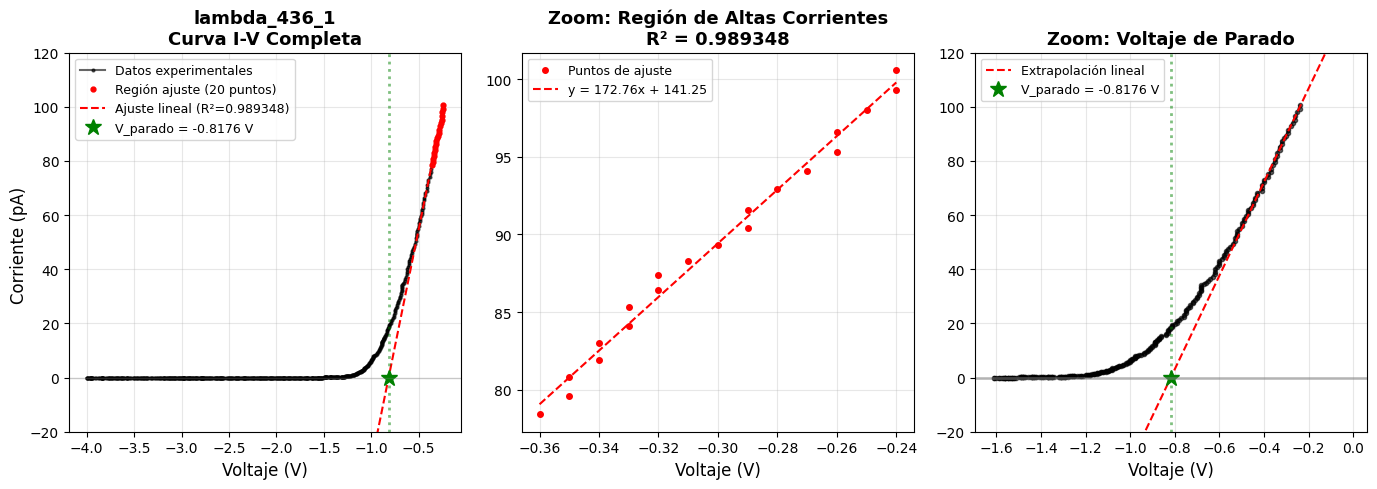


MEJOR AJUSTE ENCONTRADO para lambda_436_2:
  Número de puntos usados: 20
  Rango de voltaje: [-0.7100, -0.5800] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 271.195428 pA/V
  Intercepto (b): 259.986649 pA
  R²: 0.98612132
  Error estándar: 7.583244
  p-value: 3.57e-18

VOLTAJE DE PARADO:
  V_parado = -0.9587 V
  (Calculado como: -intercepto/pendiente)


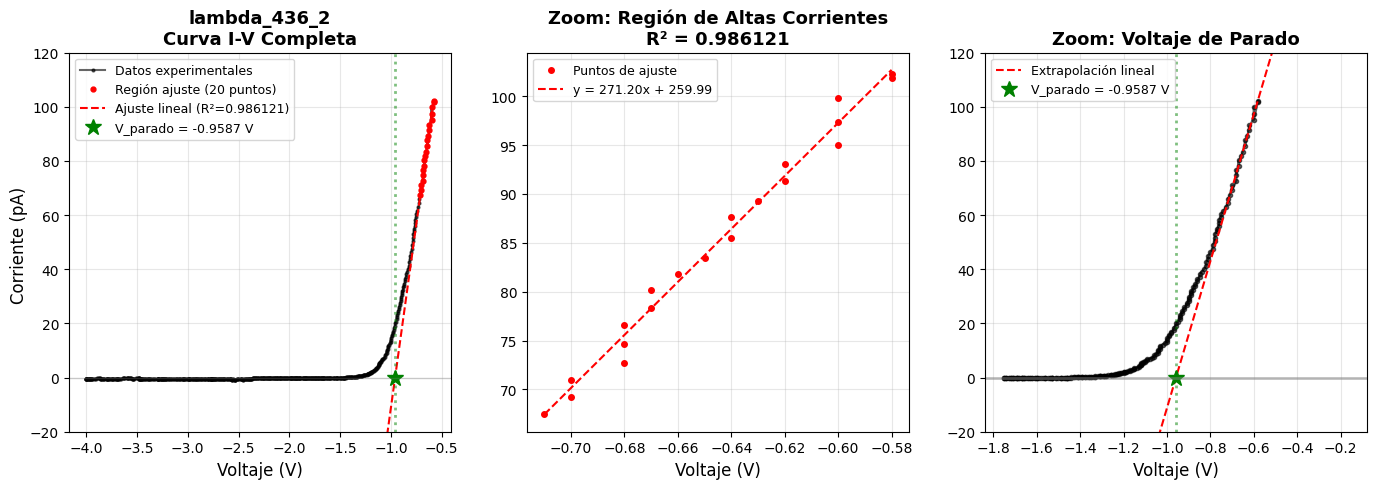


MEJOR AJUSTE ENCONTRADO para lambda_436_3:
  Número de puntos usados: 20
  Rango de voltaje: [-0.8500, -0.7300] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 351.280730 pA/V
  Intercepto (b): 364.070619 pA
  R²: 0.97960026
  Error estándar: 11.948296
  p-value: 1.15e-16

VOLTAJE DE PARADO:
  V_parado = -1.0364 V
  (Calculado como: -intercepto/pendiente)


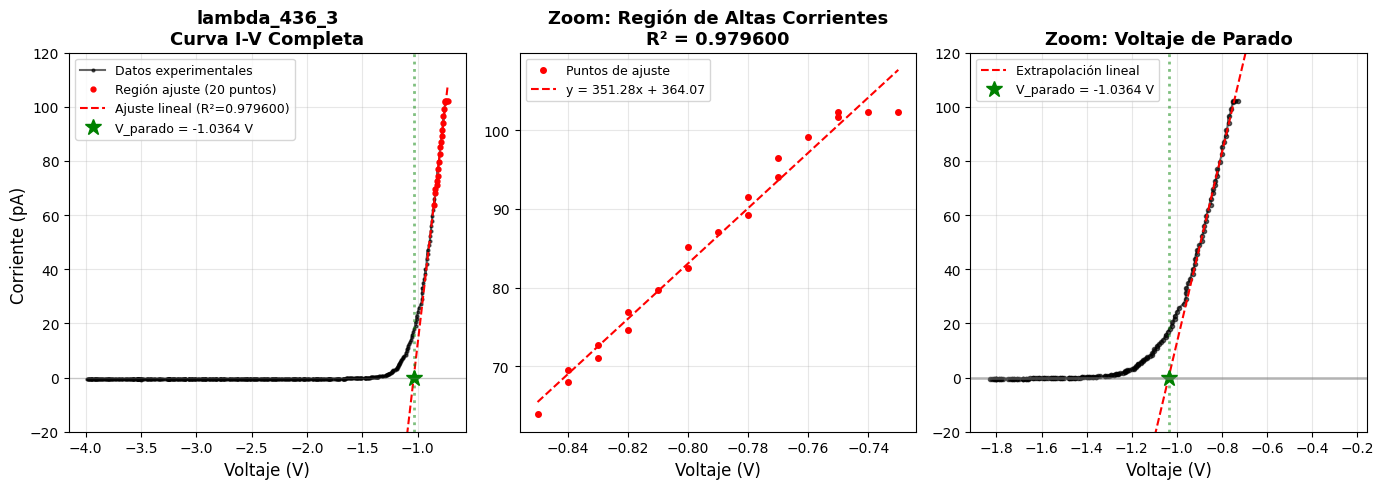


MEJOR AJUSTE ENCONTRADO para lambda_436_4:
  Número de puntos usados: 13
  Rango de voltaje: [-0.9400, -0.8200] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 446.412959 pA/V
  Intercepto (b): 466.111046 pA
  R²: 0.98224829
  Error estándar: 18.094638
  p-value: 5.57e-11

VOLTAJE DE PARADO:
  V_parado = -1.0441 V
  (Calculado como: -intercepto/pendiente)


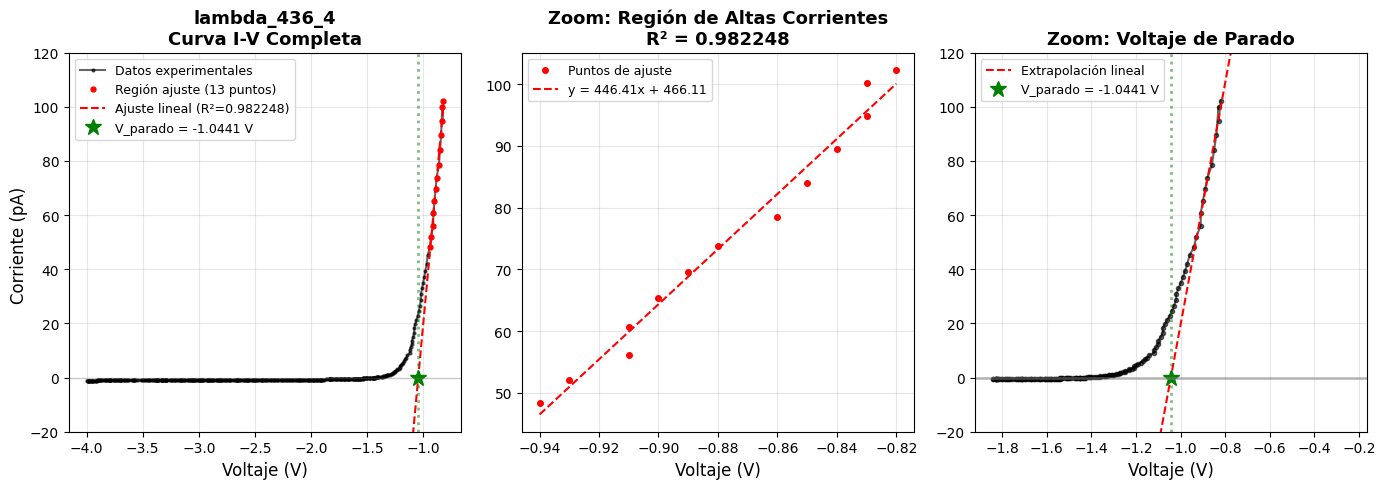


MEJOR AJUSTE ENCONTRADO para lambda_436_5:
  Número de puntos usados: 12
  Rango de voltaje: [-0.9700, -0.8700] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 373.248919 pA/V
  Intercepto (b): 428.402965 pA
  R²: 0.98712556
  Error estándar: 13.479586
  p-value: 8.75e-11

VOLTAJE DE PARADO:
  V_parado = -1.1478 V
  (Calculado como: -intercepto/pendiente)


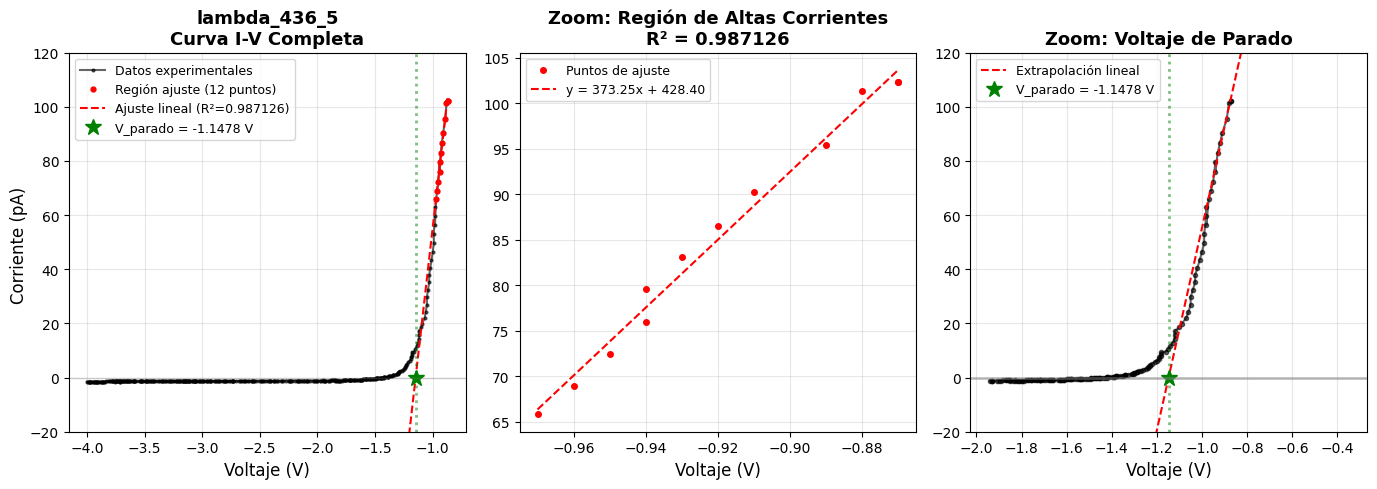


MEJOR AJUSTE ENCONTRADO para lambda_436_6:
  Número de puntos usados: 5
  Rango de voltaje: [-0.9500, -0.8900] V

PARÁMETROS DEL AJUSTE LINEAL:
  Pendiente (m): 362.692308 pA/V
  Intercepto (b): 426.596923 pA
  R²: 0.97294909
  Error estándar: 34.915932
  p-value: 1.90e-03

VOLTAJE DE PARADO:
  V_parado = -1.1762 V
  (Calculado como: -intercepto/pendiente)


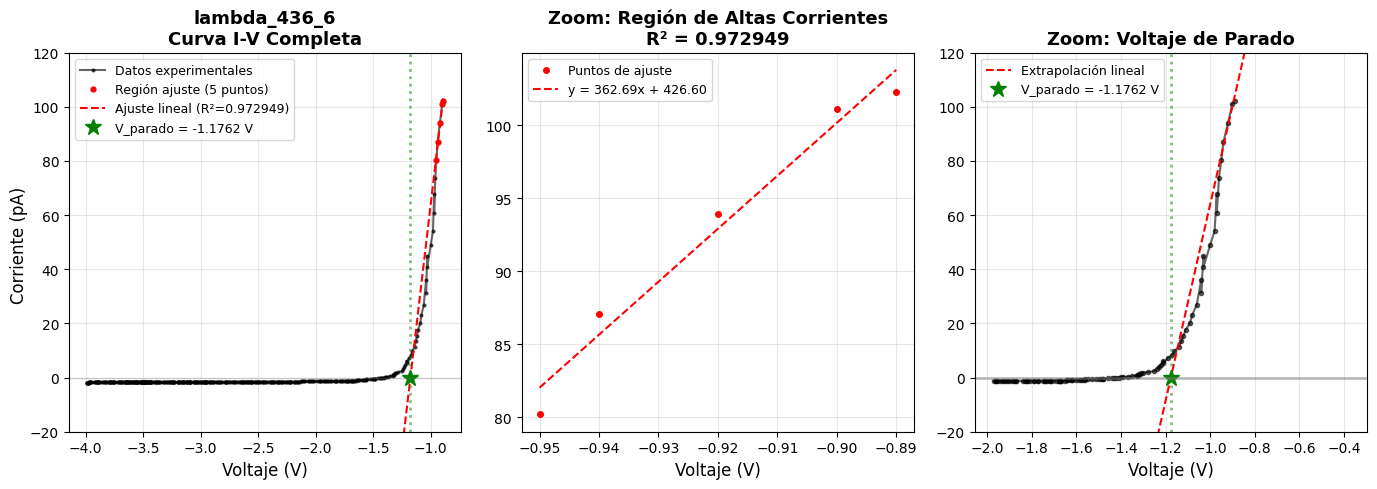

In [36]:
resultados_finales = {}

# mejor usar la data ya procesada
processed_data = {
    'apertura_1': medida_apertura_1,
    'lambda_578': medida_lambda_578,
    'lambda_436': medida_lambda_436
}

for nombre, medidas_list in processed_data.items():
    for i, medida in enumerate(medidas_list):
        voltaje = medida['U_c']
        corriente = medida['I']
        nombre_curva = f"{nombre}_{i+1}" #nombre unico para cada curva
        ajuste, v_sort, i_sort = mejor_ajuste(voltaje, corriente, nombre_curva)

        print(f"\nMEJOR AJUSTE ENCONTRADO para {nombre_curva}:")
        print(f"  Número de puntos usados: {ajuste['num_puntos']}")
        print(f"  Rango de voltaje: [{ajuste['v_min']:.4f}, {ajuste['v_max']:.4f}] V")
        print(f"\nPARÁMETROS DEL AJUSTE LINEAL:")
        print(f"  Pendiente (m): {ajuste['pendiente']:.6f} pA/V")
        print(f"  Intercepto (b): {ajuste['intercepto']:.6f} pA")
        print(f"  R²: {ajuste['r2']:.8f}")
        print(f"  Error estándar: {ajuste['std_err']:.6f}")
        print(f"  p-value: {ajuste['p_value']:.2e}")
        print(f"\nVOLTAJE DE PARADO:")
        print(f"  V_parado = {ajuste['v_parado']:.4f} V")
        print(f"  (Calculado como: -intercepto/pendiente)")

        resultados_finales[nombre_curva] = ajuste

        graficar_analisis(v_sort, i_sort, ajuste, nombre_curva)

In [23]:
def mejor_ajuste(voltaje, corriente, nombre_curva, num_puntos_min=5, num_puntos_max=20):
    """
    Prueba diferentes rangos en la región de altas corrientes y
    selecciona el que tenga el mejor R²

    Parámetros:
    - voltaje: array de voltajes
    - corriente: array de corrientes
    - nombre_curva: nombre para identificar la curva
    - num_puntos_min: mínimo número de puntos para el ajuste
    - num_puntos_max: máximo número de puntos para el ajuste
    """
    idx_sort = np.argsort(voltaje)
    v_sorted = voltaje[idx_sort]
    i_sorted = corriente[idx_sort]

    mejor_r2 = -np.inf
    mejor_ajuste = None
    mejor_num_puntos = 0

    for n_puntos in range(num_puntos_min, min(num_puntos_max+1, len(v_sorted))):
        v_region = v_sorted[-n_puntos:]
        i_region = i_sorted[-n_puntos:]

        pendiente, intercepto, r_value, p_value, std_err = stats.linregress(v_region, i_region)
        r2 = r_value ** 2

        if r2 > mejor_r2:
            mejor_r2 = r2
            mejor_ajuste = {
                'nombre': nombre_curva,
                'pendiente': pendiente,
                'intercepto': intercepto,
                'r2': r2,
                'std_err': std_err,
                'p_value': p_value,
                'v_region': v_region,
                'i_region': i_region,
                'v_min': v_region.min(),
                'v_max': v_region.max()
            }
            mejor_num_puntos = n_puntos

    v_parado = -mejor_ajuste['intercepto'] / mejor_ajuste['pendiente']
    mejor_ajuste['v_parado'] = v_parado
    mejor_ajuste['num_puntos'] = mejor_num_puntos

    return mejor_ajuste, v_sorted, i_sorted


def generar_tabla_resultados(resultados_ajustes):
    """
    Genera una tabla formateada con los resultados de los ajustes

    Parámetros:
    - resultados_ajustes: lista de diccionarios con los resultados de mejor_ajuste
    """
    datos_tabla = []

    for ajuste in resultados_ajustes:
        datos_tabla.append({
            'Curva': ajuste['nombre'],
            'V_frenado (V)': f"{ajuste['v_parado']:.4f}",
            'R²': f"{ajuste['r2']:.6f}",
            'Pendiente': f"{ajuste['pendiente']:.2f}",
            'Intercepto': f"{ajuste['intercepto']:.2f}",
            'N° Puntos': ajuste['num_puntos'],
            'Rango V (V)': f"[{ajuste['v_min']:.2f}, {ajuste['v_max']:.2f}]",
            'Error Std': f"{ajuste['std_err']:.2e}",
            'p-value': f"{ajuste['p_value']:.2e}"
        })

    df = pd.DataFrame(datos_tabla)

    # Mostrar tabla con formato
    print("\n" + "="*120)
    print("RESULTADOS DEL ANÁLISIS DE VOLTAJES DE FRENADO")
    print("="*120)
    print(df.to_string(index=False))
    print("="*120 + "\n")

    return df


def resumen_estadistico(df_resultados):
    """
    Genera un resumen estadístico de los voltajes de frenado

    Parámetros:
    - df_resultados: DataFrame retornado por generar_tabla_resultados
    """
    # Convertir strings a números para el análisis
    v_frenado = df_resultados['V_frenado (V)'].astype(float)
    r2 = df_resultados['R²'].astype(float)

    print("\nRESUMEN ESTADÍSTICO")
    print("-" * 60)
    print(f"Voltaje de Frenado Promedio:  {v_frenado.mean():.4f} V")
    print(f"Desviación Estándar:          {v_frenado.std():.4f} V")
    print(f"Voltaje Mínimo:               {v_frenado.min():.4f} V")
    print(f"Voltaje Máximo:               {v_frenado.max():.4f} V")
    print(f"Rango:                        {v_frenado.max() - v_frenado.min():.4f} V")
    print(f"\nR² Promedio:                  {r2.mean():.6f}")
    print(f"R² Mínimo:                    {r2.min():.6f}")
    print(f"R² Máximo:                    {r2.max():.6f}")
    print("-" * 60 + "\n")

In [24]:
#@title Lista para almacenar todos los resultados
todos_los_ajustes = []

for nombre_curva, ajuste_dict in resultados_finales.items():

    dataset_name = '_'.join(nombre_curva.split('_')[:-1])
    dataset_index = int(nombre_curva.split('_')[-1]) - 1

    if dataset_name in processed_data and dataset_index < len(processed_data[dataset_name]):
        medida = processed_data[dataset_name][dataset_index]
        voltaje = medida['U_c']
        corriente = medida['I']
        # Now call mejor_ajuste with the correct voltage and current data
        ajuste, v_sorted, i_sorted = mejor_ajuste(voltaje, corriente, nombre_curva)
        todos_los_ajustes.append(ajuste)
    else:
        print(f"Warning: Could not find original data for curve {nombre_curva}. Skipping.")


# Generar tabla con todos los resultados
df_resultados = generar_tabla_resultados(todos_los_ajustes)

# Mostrar resumen estadístico
resumen_estadistico(df_resultados)


RESULTADOS DEL ANÁLISIS DE VOLTAJES DE FRENADO
       Curva V_frenado (V)       R² Pendiente Intercepto  N° Puntos    Rango V (V) Error Std  p-value
apertura_1_1       -0.3807 0.983993    410.60     156.33         14 [-0.29, -0.14]  1.51e+01 3.82e-12
apertura_1_2       -0.5836 0.988544    433.07     252.73         13 [-0.52, -0.36]  1.41e+01 4.99e-12
apertura_1_3       -0.9513 0.977660    268.27     255.20         20 [-0.69, -0.58]  9.56e+00 2.60e-16
apertura_1_4       -1.1596 0.973618    288.25     334.24         20 [-0.99, -0.82]  1.12e+01 1.16e-15
apertura_1_5       -1.5577 0.970997    291.34     453.82         20 [-1.38, -1.24]  1.19e+01 2.73e-15
lambda_578_1       -0.3159 0.992004    334.37     105.64         17 [-0.16, -0.01]  7.75e+00 3.80e-17
lambda_578_2       -0.3581 0.971825    553.36     198.17         15 [-0.29, -0.17]  2.61e+01 1.85e-11
lambda_578_3       -0.4604 0.989004    523.82     241.18         20 [-0.40, -0.26]  1.30e+01 4.38e-19
lambda_578_4       -0.4812 0.97685

## Método 3: Regresión no lineal con la ecuación de Shockley para un diodo

Para este método se toman valores únicamente en la región de transición donde empieza a aparecer la fotocorriente. Esta región debería tener un comportamiento de la forma

$$
I(U) = A \left[e^{B\left(U - C\right)} - 1\right]
$$

donde $A$ sería un término relacionado con corrientes oscuras (emergente de fenómenos térmicos), $B$ está relacionado con la intensidad de la luz por la respuesta del fotocátodo y $C$ sería el voltaje de frenado.

En este caso, dado el $-1$ en la ecuación, no es posible encontrar transformaciones $X = X(I, U)$ y $Y = Y(I, U)$ que permitan linealizar el sistema de la forma $Y = aX + b$ y usar el método de mínimos cuadrados ordinario, para solucionar esto se va a utilizar [la función `curve_fit()` de la librería de `scipy.optimize`](https://en.wikipedia.org/wiki/Non-linear_least_squares#Marquardt_parameter) que emplea el método de regresión de regresión [no lineal por mínimos cuadrados (NLS en inglés)](https://en.wikipedia.org/wiki/Non-linear_least_squares) de la que [el algoritmo por defecto](https://en.wikipedia.org/wiki/Non-linear_least_squares#Marquardt_parameter) se pueden obtener el valor de tantos parámetros como observaciones se tenga.

Este método inicialmente necesita una suposición sobre el valor de todos los parámetros de la curva a ajustar (`p0=beta_guess`, similar al método de Newton-Rhapson) así como también la forma funcional del la curva que será ajustada. De igual forma que en el método de Newton-Rhapson, las suposiciones sobre los parámetros pueden tomar más tiempo llegando a un valor estable (también parece que tiene un número de iteraciones máximo, entonces este `guess` podría afectar también la precisión) o incluso no estabilizarse en lo absoluto.

Otra consideración importante es que, a pesar de poder tener tantos parámetros de ajuste como observaciones se tengan (e incluso más parámetros con otros algoritmos), si se sobreparametriza la curva de ajuste se podrían producir ajustes no tan buenos. En caso de querer ver si una curva tiene este problema se puede ver la [condición de la matriz](https://en.wikipedia.org/wiki/Condition_number) de covarianza `pcov` como `numpy.linalg.cond(pcov)`, si dicho número es muy grande, seguramente la forma funcional del ajuste tenga estos problemas.

Por último, dada la no linealidad, el factor de correlación lineal no es una buena medida sobre que tan bueno es el ajuste representado, en este caso, el mejor 'cuantificador' de qué tan bueno es un ajuste por NLS es el error estándar de los parámetros (se puede sacar de la diagonal de la matriz de covarianza sobre el número de observaciones y luego se le saca raíz cuadrada a cada elemento).

In [25]:
#@title Ecuación de Shockley para un diodo como función de ajuste
def shockley(U, A, B, C):
  return A * (np.exp(B * (U - C)) - 1)



In [26]:
#@title Función de regresión NLS para el experimento
def NLS_regr(medida, beta_guess, rango_transicion):
  beta = []
  mcov = []
  Ns = np.empty(len(medida))

  if len(rango_transicion) == 2:
    rango_transicion = [rango_transicion]*len(medida)
  if len(beta_guess) == 3:
    beta_guess = [beta_guess]*len(medida)

  for i in range(len(medida)):
    x = medida[i]['U_c']
    y = medida[i]['I']# - np.min(medida[i]['I']) + 0.1
    mask = (x >= rango_transicion[i][0]) & (x <= rango_transicion[i][1])

    # Increased maxfev
    beta_i, mcov_i = curve_fit(shockley, x[mask], y[mask], p0=beta_guess[i], maxfev=5000)
    beta.append(beta_i)
    mcov.append(mcov_i)
    Ns[i] = np.sum(mask)

  beta = np.transpose(np.array(beta, dtype=np.float64))
  mcov = np.array(mcov, dtype=np.float64)
  SEMs = np.transpose(np.sqrt(np.array([np.diag(matrix) / Ns[i] for i, matrix in enumerate(mcov)])))

  return beta, SEMs



In [27]:
#@title Ajuste medidas con $\lambda = 578 \text{ nm}$ fijo
beta_578, SEMs_578 = NLS_regr(medida_lambda_578, np.array([10, 1, -0.6], dtype=np.float64), [-0.8, -0.55])
df = pd.DataFrame({
  'Apertura': [medida['parametro_variable'] for medida in medida_lambda_578],
  'A [pA]': beta_578[0],
  'SEM A [pA]': SEMs_578[0],
  'B [V⁻¹]': beta_578[1],
  'SEM B [V⁻¹]': SEMs_578[1],
  'C [V]': beta_578[2],
  'SEM C [V]': SEMs_578[2],
})
df.set_index('Apertura', inplace=True)

error = np.sqrt(np.mean(SEMs_578[2][1:])**2 + (t.ppf(.975, 4)**2)*np.var(beta_578[2][1:], ddof=1)/len(beta_578[2][1:]))
print(f'Voltaje de frenado promedio (sin apertura 0.5) = ({np.mean(beta_578[2][1:]):.2f} ± {error:.2f}) V')
display(df)

Voltaje de frenado promedio (sin apertura 0.5) = (-0.74 ± 0.02) V


,A [pA],SEM A [pA],B [V⁻¹],SEM B [V⁻¹],C [V],SEM C [V]
Apertura,,,,,,
0.5,0.000001,0.002412,18.802270,0.154172,-1.286561,103.396440
1.0,0.033061,0.003942,21.571677,0.171968,-0.755948,0.004443
1.5,0.144323,0.006541,19.956995,0.110419,-0.728888,0.001592
2.0,0.120469,0.008197,20.505762,0.119034,-0.751867,0.002592
2.5,0.288506,0.015256,21.900361,0.140288,-0.716697,0.001712
3.0,0.612282,0.014341,16.564717,0.076583,-0.737391,0.000828


In [28]:
#@title Ajuste medidas con $\lambda = 436 \text{ nm}$ fijo
beta_436, SEMs_436 = NLS_regr(medida_lambda_436, np.array([4, 6, -1.3], dtype=np.float64), [-1.5, -0.8])
df = pd.DataFrame({
  'Apertura': [medida['parametro_variable'] for medida in medida_lambda_578],
  'A [pA]': beta_436[0],
  'SEM A [pA]': SEMs_436[0],
  'B [V⁻¹]': beta_436[1],
  'SEM B [V⁻¹]': SEMs_436[1],
  'C [V]': beta_436[2],
  'SEM C [V]': SEMs_436[2],
})
df.set_index('Apertura', inplace=True)

error = np.sqrt(np.mean(SEMs_436[2][1:])**2 + (t.ppf(.975, 4)**2)*np.var(beta_436[2][1:], ddof=1)/len(beta_436[2][1:]))
print(f'Voltaje de frenado promedio (sin apertura 0.5) = ({np.mean(beta_436[2][1:]):.2f} ± {error:.2f}) V')
display(df)

Voltaje de frenado promedio (sin apertura 0.5) = (-1.35 ± 0.01) V


,A [pA],SEM A [pA],B [V⁻¹],SEM B [V⁻¹],C [V],SEM C [V]
Apertura,,,,,,
0.5,0.788277,0.006904,5.847539,0.007739,-1.367506,0.000943
1.0,2.317082,0.021803,5.755323,0.010101,-1.341905,0.000948
1.5,3.398550,0.034051,6.083111,0.009583,-1.340919,0.001026
2.0,3.686351,0.046990,6.202363,0.012386,-1.364979,0.001301
2.5,4.871013,0.087017,6.461413,0.021456,-1.363688,0.001649
3.0,4.101577,0.153331,7.278972,0.042312,-1.351443,0.003326


In [29]:
#@title Ajuste medidas con $A = 1 \text{ u.a.l}$ fijo
regiones_transicion =  np.array([[-0.9, -0.35], [-1.1, -0.55], [-1.6, -0.95], [-1.9, -1.2], [-2.2, -1.55]], dtype=np.float64)
beta_guess = np.array([[0.7, 10, -0.33], [0.4, 10, -0.8], [0.2, 10, -1.4], [0.07, 10, -1.7], [0.008, 10, -2.4]], dtype=np.float64)
beta_A1, SEMs_A1 = NLS_regr(medida_apertura_1, beta_guess, regiones_transicion)
df = pd.DataFrame({
  'λ [±2 nm]': [medida['parametro_variable'] for medida in medida_apertura_1],
  'A [pA]': beta_A1[0],
  'SEM A [pA]': SEMs_A1[0],
  'B [V⁻¹]': beta_A1[1],
  'SEM B [V⁻¹]': SEMs_A1[1],
  'C [V]': beta_A1[2],
  'SEM C [V]': SEMs_A1[2],
})
df.set_index('λ [±2 nm]', inplace=True)

display(df)

,A [pA],SEM A [pA],B [V⁻¹],SEM B [V⁻¹],C [V],SEM C [V]
λ [±2 nm],,,,,,
578,0.376372,0.021320,10.951884,0.053908,-0.735755,0.004118
546,0.332664,0.008402,13.040630,0.034734,-0.870387,0.001562
436,0.232477,0.013726,8.953905,0.030724,-1.438262,0.005486
405,0.069728,0.005105,9.260254,0.018468,-1.777683,0.007153
365,0.008551,0.009008,9.105555,0.020196,-2.404619,0.114168


In [30]:
#@title Constante de Planck y frecuencia umbral
frecs = np.array([299792458 / (medida['parametro_variable'] * 1e-9) for medida in medida_apertura_1], dtype=np.float64)
Delta_frecs = np.array([299792458 * 2 / ((medida['parametro_variable']**2)) for medida in medida_apertura_1], dtype=np.float64)
Voltajes_frenado = -np.array(df['C [V]'], dtype=np.float64)
Delta_Voltajes_frenado = np.array(df['SEM C [V]'], dtype=np.float64)

M, B, Delta_M, Delta_B, R = OLS_regr(frecs, Voltajes_frenado)
x_lims = np.array([3.8e+14, 8.6e+14])

frec_umbral_exp = -B / M
Delta_frec_umbral_exp = frec_umbral_exp * np.sqrt((Delta_B / B)**2 + (Delta_M / M)**2)
const_planck = M #/ 1.602176634e-19
Delta_const_planck = Delta_M #/ 1.602176634e-19

regr_label = f'$U_0 = ({M*1e+15:.0f} \\pm {Delta_M*1e+15:.0f})' + '\\times 10^{-15} \\; \\nu + ' f'({-B:.1f} \\pm {Delta_B:.1f})$'

In [31]:
print(f'Frecuencia umbral experimental = ({frec_umbral_exp:.0e} ± {Delta_frec_umbral_exp:.0e}) Hz')
print(f'Constante de Planck experimental = ({const_planck:.1e} ± {Delta_const_planck:.0e}) eV s')
print(f'Función trabajo = ({-B:.1f} ± {Delta_B:.1f}) eV')

Frecuencia umbral experimental = (4e+14 ± 2e+14) Hz
Constante de Planck experimental = (5.3e-15 ± 1e-15) eV s
Función trabajo = (2.1 ± 0.9) eV


R² = 0.9769


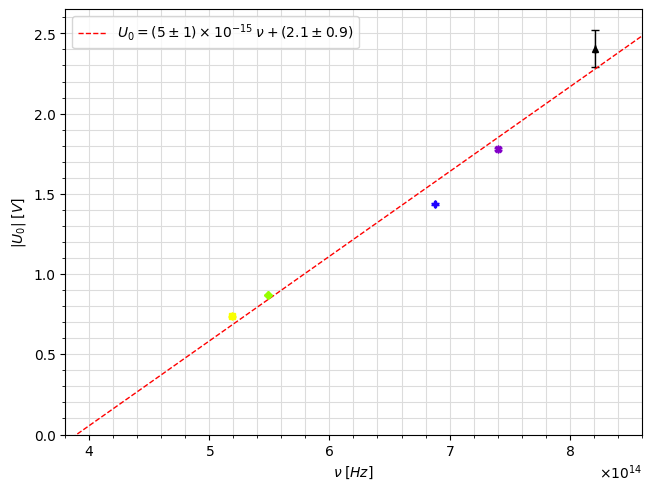

In [32]:
#@title Gráfica $\vert U_0 \vert$ contra $\nu$
fig, ax = plt.subplots(layout='constrained')
for i in range(len(frecs)):
  ax.errorbar(
    frecs[i],
    Voltajes_frenado[i],
    xerr=Delta_frecs[i],
    yerr=Delta_Voltajes_frenado[i],
    capsize=3,
    c=colores_apertura_1[i],
    ecolor=colores_apertura_1[i],
    elinewidth=1,
    fmt=markers[i],
    ms=4.5,
    zorder=2,
  )
ax.plot(
  x_lims,
  x_lims * M + B,
  ls='--',
  c='r',
  lw=1,
  label=regr_label,
  zorder=2,
)
ax.grid(True, which='both', color='gainsboro')
ax.minorticks_on()
ax.set_xlim(x_lims)
ax.set_ylim([0, 2.65])
ax.set_xlabel('$\\nu \\; [Hz]$')
ax.set_ylabel('$\\vert U_0 \\vert \\; [V]$')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
ax.legend()
print(f'R² = {R**2:.4f}')